# P6: ENT-icipate
**Goal**: Predicting Surgical Complications for patients who underwent a tumor removal surgery in Ear-Nose-Throat (ENT) area (project in collaboration with **Hospital Molinette** and supervised by **Links Foundation**)

## Why This Matters
Surgery for Ear, Nose, and Throat (ENT) cancers is complex and carries significant risks. Some patients experience serious post-operative complications, such as tissue breakdown (fistula) or hospital-acquired infections. Predicting which patients are at higher risk using preoperative and perioperative data can help surgeons intervene early, personalize post-operative care, and allow hospital managers to allocate resources more effectively.
This project is supervised by LINKS Foundation in collaboration with the ENT Ward of Molinette Hospital and focuses on providing actionable, clinically relevant predictions to improve patient safety and operational planning.

---

## What We're Trying to Do

We are developing machine learning models to predict two major post-surgery complications:
- **Fistula** (when tissue breaks down and creates an abnormal opening) - happens in about 8% of patients
- **Infection** (nosocomial infection acquired in the hospital) - happens in about 24% of patients

We use patient data collected before and during surgery—such as age, comorbidities, TNM staging, and type of procedure—to train models that can reliably predict these outcomes. The dataset includes 574 patients who underwent ENT tumor removal surgery between 2002 and 2023, with manually collected clinical and surgical records approved for research by the hospital’s Ethics Committee.

Because these complications are relatively rare, careful model design and evaluation are critical.
Standard accuracy metrics are insufficient—for instance, always predicting “no complication” would yield high accuracy for fistulas but would be clinically meaningless. Our models are designed to prioritize high recall, ensuring that high-risk patients are correctly identified for early intervention and personalized post-operative management, but also tried to minimize the number of false alarms.

---
#  Project Overview

This notebook implements an end-to-end workflow to predict two post-operative outcomes — fistula and nosocomial infection — using scikit-learn/ImbPipeline models and to interpret predictions with SHAP. The pipeline covers preprocessing (imputation, scaling, one-hot encoding), model selection via cross-validation, threshold tuning, evaluation on a held-out test set, and model interpretability (feature importance and SHAP visualizations).


# Section 1: Data Loading and Initial Exploration

First, we load the data from the Excel file. The dataset has some quirks - the column names are spread across multiple rows, so we need to clean that up first. Once we load it, we should have around 577 patient records before we start removing data with missing values.

Let's start by loading the data and taking a quick look at what we're working with.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the dataset
df = pd.read_excel("Dataset_ENTicipate.xlsx")

# Feature names is sometimes in all 3 first lines sometime only in the second line
new_columns = []
for col_idx, col_name in enumerate(df.columns):
    if "Unnamed" in str(col_name) or col_name is None:
        # Substitute with value in line 0
        new_columns.append(str(df.iloc[0, col_idx]))
    else:
        new_columns.append(col_name)

# Update the columns name
df.columns = new_columns

df = df.drop(index=[0,1]).reset_index(drop=True)
df.columns = df.columns.str.replace('\n', '', regex=True)

df.rename(columns={
    'Type of surgical procedure (1 partial glossectomy, 2 hemiglossectomy, 3 subtotal/total glossectomy, 4 commando, 5 pharyngectomy, 6 cordectomy, 7 partial laryngectomy, 8 total laryngectomy, 9 PAROTID GLANDctomy, 10 emptying only, 11 thyroidectomy, 12 rhinectomy, 13 maxillectomy, 14 lip excision, 15 ear excision, 16 pharyngolaryngectomy, 17 pharyngoglossectomy, 18 pelvectomy, 19 other procedures)': 'Type of surgical procedure',
}, inplace=True)

print("✓ Dataset loaded successfully")
print(f"Shape: {df.shape}")
df.head()

✓ Dataset loaded successfully
Shape: (574, 64)


,ID,Site,Site ID,Sex (0: male; 1: female),Age > 65 years old,Age at diagnosis,Weight (Kg),Usual weight (maintained for at least 6 months),Weight loss (kg),Significant weight loss? (0: no; 1: yes),...,Wound dehiscence,Pulmonary thromboembolism,Complete necrosis of the flap,Partial necrosis of the flap,Necrosis (overall),Other complications,Hypertensive crisis,Any complication,Score Clavien-Dindo (tenere conto della complicanza peggiore),Nosocomial infection
0,1.0,LARYNX,4,0.0,0,64.0,75.0,75.0,0.0,0,...,0.0,0.0,0.0,0.0,0,1.0,0,1,IIIB,1.0
1,2.0,HYPOPHARYNX,5,0.0,0,61.0,70.0,70.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,LARYNX,4,0.0,0,54.0,112.0,112.0,0.0,0,...,0.0,0.0,0.0,0.0,0,1.0,0,1,II,0.0
3,4.0,LARYNX,4,0.0,1,66.0,72.0,72.0,0.0,0,...,0.0,0.0,0.0,0.0,0,0.0,0,1,II,1.0
4,5.0,UNKNOWN FOCUS,7,0.0,0,61.0,75.0,75.0,0.0,0,...,0.0,0.0,0.0,0.0,0,1.0,0,1,I,0.0


In [2]:
# 2.1 Dataset Structure Overview
print("=" * 80)
print("DATASET INFORMATION")
print("=" * 80)
print(df.info())

print("\n" + "=" * 80)
print("DESCRIPTIVE STATISTICS")
print("=" * 80)
print(df.describe())

print("\n" + "=" * 80)
print("UNIQUE VALUES")
print("=" * 80)
for col in df.columns:
    print(f"\n--- {col} ---")
    print(df[col].unique())

DATASET INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574 entries, 0 to 573
Data columns (total 64 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   ID                                                             574 non-null    float64
 1   Site                                                           574 non-null    object 
 2   Site ID                                                        574 non-null    object 
 3   Sex (0: male; 1: female)                                       574 non-null    float64
 4   Age > 65 years old                                             574 non-null    object 
 5   Age at diagnosis                                               574 non-null    float64
 6   Weight (Kg)                                                    574 non-null    float64
 7   Usual weight (maintained for at least 6 mo

## Understanding the Data Structure

Now let's get a better sense of the dataset. We need to see what types of variables we have (numerical vs categorical), how much missing data there is, and what the descriptive statistics look like. This will help us plan our preprocessing steps.
So we perform integrity checks for missing values, and inspect distributions. Critical columns are identified and non-informative columns are removed when necessary.

In [3]:
# 2.2 Data Cleaning - Standardize Inconsistencies
print("\n" + "=" * 80)
print("DATA CLEANING: Standardizing Inconsistent Values")
print("=" * 80)

# Standardize target variables
df['Pharyngo-/oro-cutaneous fistula'] = df['Pharyngo-/oro-cutaneous fistula'].replace(
    {'fistola oro-cutanea 24/4 per cedimento delle suture endorali': 1}
)

# Standardize Diabetes: recode 'intolleranza glucidica modesta' as 0 (treat as no intolleranza)
df['Diabetes'] = df['Diabetes'].replace({'intolleranza glucidica modesta': 0}).astype(float)

# Standardize Post-op PACU/ICU: recode 2 as 1 (treat as "yes")
df['Post-op PACU or ICU'] = df['Post-op PACU or ICU'].replace(2, 1).astype(float)

print("✓ Target variables standardized")


DATA CLEANING: Standardizing Inconsistent Values
✓ Target variables standardized


/var/folders/00/rmyrh4xx41s8wcl9ysjn05ch0000gn/T/ipykernel_29663/2957571087.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Pharyngo-/oro-cutaneous fistula'] = df['Pharyngo-/oro-cutaneous fistula'].replace(
/var/folders/00/rmyrh4xx41s8wcl9ysjn05ch0000gn/T/ipykernel_29663/2957571087.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Diabetes'] = df['Diabetes'].replace({'intolleranza glucidica modesta': 0}).astype(float)


## Cleaning Up Messy Data

The dataset has some inconsistencies. For example, some values in target columns are written as text instead of numbers (like "fistola oro-cutanea..." instead of just 1). We need to fix these before we can use the data properly. Once we clean these up, we can look at the distribution of complications.


TARGET VARIABLE DISTRIBUTIONS


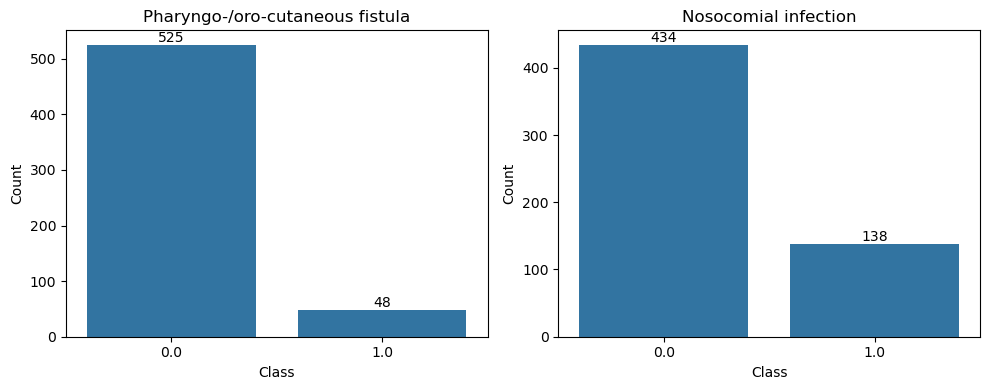


Fistula - Positive: 48.0 (8.4%)
Infection - Positive: 138.0 (24.0%)


In [4]:
# 2.3 Target Variable Distribution Analysis
print("\n" + "=" * 80)
print("TARGET VARIABLE DISTRIBUTIONS")
print("=" * 80)

target_columns = ['Pharyngo-/oro-cutaneous fistula', 'Nosocomial infection']

fig, axes = plt.subplots(1, 2, figsize=(10,4))

for idx, target in enumerate(target_columns):
  sns.countplot(data=df, x=target, ax=axes[idx])
  axes[idx].set_title(f"{target}")
  axes[idx].set_ylabel("Count")
  axes[idx].set_xlabel("Class")
  for p in axes[idx].patches:
        height = p.get_height()
        axes[idx].annotate(f'{int(height)}',
                          (p.get_x() + p.get_width() / 2., height),
                          ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\nFistula - Positive: {df[target_columns[0]].sum()} ({100*df[target_columns[0]].sum()/len(df):.1f}%)")
print(f"Infection - Positive: {df[target_columns[1]].sum()} ({100*df[target_columns[1]].sum()/len(df):.1f}%)")

## The Class Imbalance Problem

Now we can see the complications are imbalanced - most patients don't have complications. This is realistic but creates challenges for machine learning. A model that just predicts "no complication" for everyone would seem accurate but would miss all the positive cases we actually care about. We'll need to use appropriate metrics (like PR-AUC instead of regular accuracy) and techniques like class weighting to handle this properly.

# Section 2: Data Preprocessing & Cleaning

## 2.1 Feature Engineering - TNM Staging Encoding

Convert TNM staging variables from categorical/roman numerals to numerical codes.

In [5]:
import re
import numpy as np
import pandas as pd


# -----------------------------
# Roman numerals mapping
# -----------------------------
ROMAN_MAP = {
    "iv": "4",
    "iii": "3",
    "ii": "2",
    "i": "1"
}


# -----------------------------
# T normalization
# -----------------------------
def normalize_T(v):
    if pd.isna(v):
        return np.nan

    s = str(v).strip().lower()

    # Remove leading "T"
    s = re.sub(r"^t\s*", "", s)

    # Non-assessable
    if s in {"x", "tx"}:
        return np.nan

    # Tis → intermediate value
    if s in {"is", "tis"}:
        return 0.5

    # Roman numerals → arabic
    for r, a in ROMAN_MAP.items():
        if s.startswith(r):
            s = a + s[len(r):]
            break

    # Extract first digit (0–4)
    match = re.match(r"^([0-4])", s)
    return int(match.group(1)) if match else np.nan


# -----------------------------
# N / Stage normalization
# -----------------------------
def normalize_N_stage(v):
    if pd.isna(v):
        return np.nan

    s = str(v).strip().lower()

    # Remove leading N or T
    s = re.sub(r"^[nt]\s*", "", s)

    # Non-assessable
    if s in {"x", "nx"}:
        return np.nan

    # Roman numerals → arabic
    for r, a in ROMAN_MAP.items():
        if s.startswith(r):
            s = a + s[len(r):]
            break

    # Extract first digit (0–4)
    match = re.match(r"^([0-4])", s)
    return int(match.group(1)) if match else np.nan


# -----------------------------
# Apply normalization
# -----------------------------
df["T"] = df["T"].apply(normalize_T)
df["N"] = df["N"].apply(normalize_N_stage)
df["Stage"] = df["Stage"].apply(normalize_N_stage)


## 2.2 Data Type Standardization & Feature Selection

In [6]:
# 2.2a Data Type Standardization
print("\n" + "=" * 80)
print("DATA TYPE STANDARDIZATION & FEATURE SELECTION")
print("=" * 80)

# Transform object type columns into numerical type
cols = ["Age > 65 years old","Significant weight loss? (0: no; 1: yes)","Vascular comorbidities", "High blood pressure"]
df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")

# Numerical columns but in reality they are categorical
cat_cols = [
    "Type of surgical procedure", "Smoking (0: no; 1: yes; 2: ex)",
    "Alcohol (0: no; 1: yes, 2: ex)", "Type of surgery (1=clean, 2=clean-contaminated)","0: normal weight; 1: underweight; 2: overweight"
]
df[cat_cols] = df[cat_cols].astype("object")

print(f"✓ Standardized {len(cols)} numeric columns")
print(f"✓ Classified {len(cat_cols)} categorical columns")


DATA TYPE STANDARDIZATION & FEATURE SELECTION
✓ Standardized 4 numeric columns
✓ Classified 5 categorical columns


## 2.2b Exploratory Correlation Analysis - Identifying Redundant Features

Before we decide which features to keep, let's look at the correlation matrix to identify redundant or highly correlated features. Some features might be measuring the same thing (like ASA score and Divided ASA score), so we should keep only one to avoid multicollinearity.


MULTICOLLINEARITY ASSESSMENT (Full Dataset)


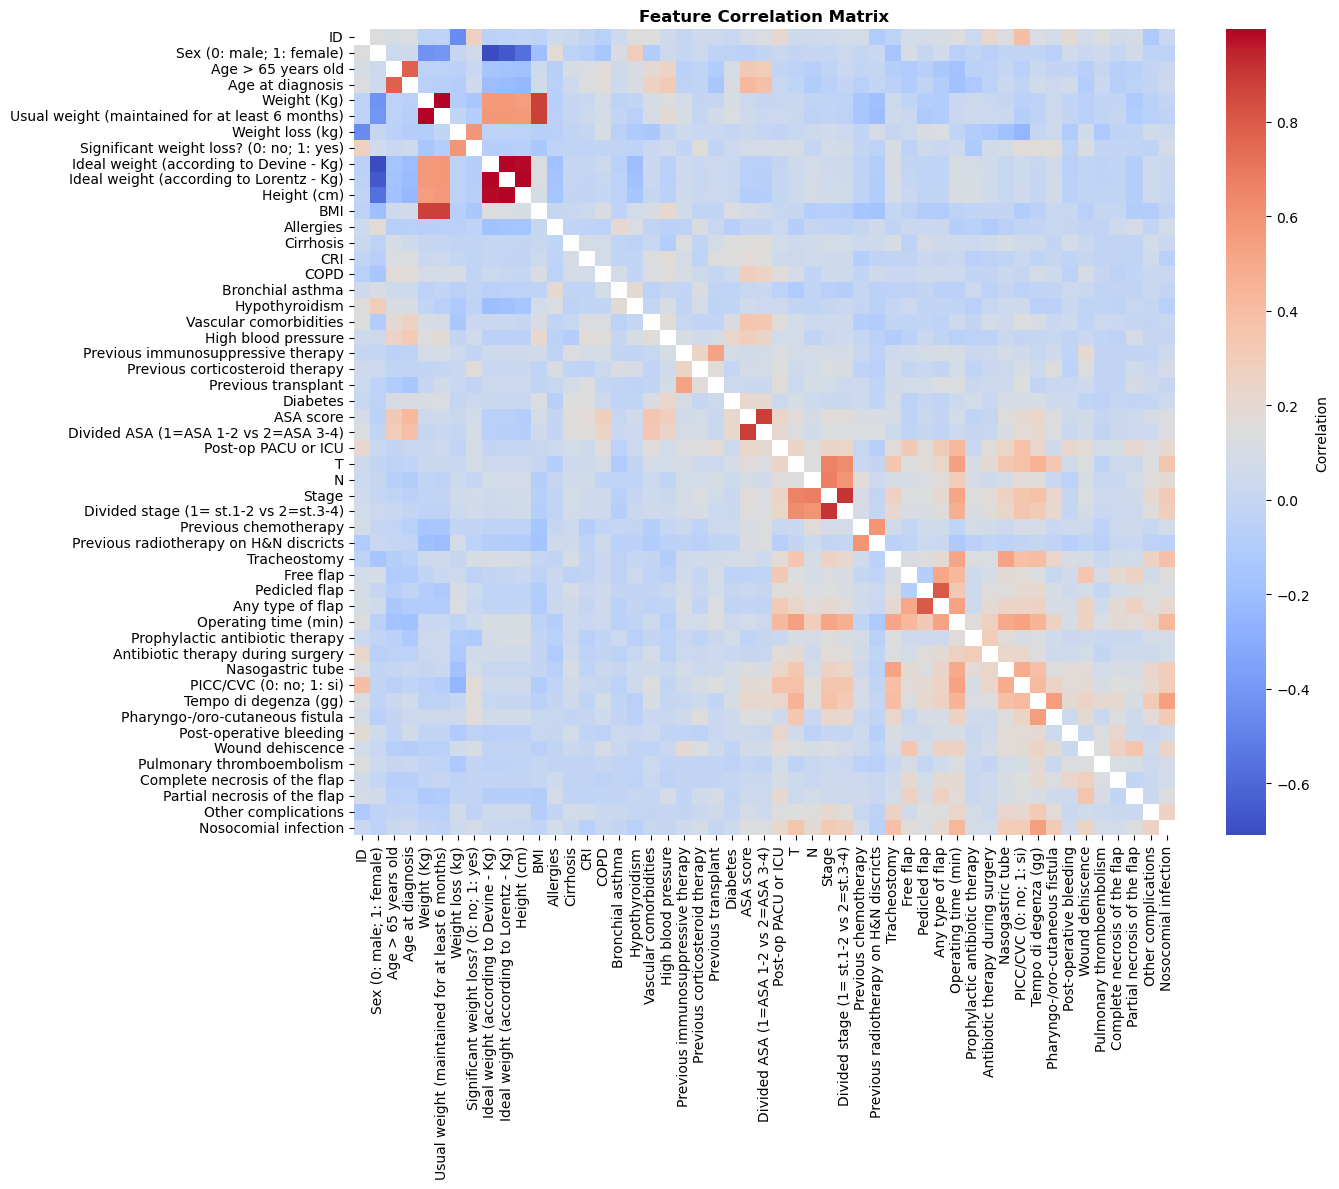

In [7]:
print("\n" + "=" * 80)
print("MULTICOLLINEARITY ASSESSMENT (Full Dataset)")
print("=" * 80)

num_cols = df.select_dtypes(include=np.number).columns.tolist()
corr = df.corr(numeric_only=True)

# Remove self-correlations for clarity
corr_no_diag = corr.copy()
np.fill_diagonal(corr_no_diag.values, np.nan)

valid_vals = corr_no_diag.values[~np.isnan(corr_no_diag.values)]
vmin, vmax = valid_vals.min(), valid_vals.max()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_no_diag, cmap='coolwarm', vmin=vmin, vmax=vmax, cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlation Matrix', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## 2.3 Removing Redundant Features Based on Correlation Analysis

Looking at the correlation matrix, we can see several features that are highly correlated with each other:
- **ASA score** and **Divided ASA** are nearly identical - they're just two different ways of coding the same information
- **Stage** and **Divided stage** have very high correlation - same issue
- Other redundant features like ideal weight calculations, height, weight that are derived from BMI

Since these represent the same underlying information, keeping all of them would introduce multicollinearity without adding new information. We'll keep only one version of each and remove the redundant ones. We also remove non-target outcome variables that won't be used for prediction.

In [8]:
# 2.2b Drop Non-Target Outcomes & Redundant Features
nc_targets = ['Tempo di degenza (gg)','Score Clavien-Dindo (tenere conto della complicanza peggiore)',
              'Post-operative bleeding','Wound dehiscence','Pulmonary thromboembolism',
              'Complete necrosis of the flap','Partial necrosis of the flap','Necrosis (overall)',
              'Other complications','Hypertensive crisis','Any complication']
df = df.drop(columns=nc_targets)

# Drop derived/redundant features
columns_to_drop = ['ID','Site','Prophylactic antibiotic therapy (dosage)',
                   'Antibiotic therapy during surgery (dosage)','Ideal weight (according to Devine - Kg)',
                   'Age > 65 years old','Any type of flap','Height (cm)','Weight (Kg)',
                   'Divided ASA (1=ASA 1-2 vs 2=ASA 3-4)','Divided stage (1= st.1-2 vs 2=st.3-4)',
                   'Usual weight (maintained for at least 6 months)',
                   'Ideal weight (according to Lorentz - Kg)','Weight loss (kg)']
df = df.drop(columns=columns_to_drop, errors='ignore')

print(f"✓ Removed {len(nc_targets)} non-target outcomes")
print(f"✓ Removed {len(columns_to_drop)} redundant features")
print(f"  Remaining features: {df.shape[1]}")

✓ Removed 11 non-target outcomes
✓ Removed 14 redundant features
  Remaining features: 39


In [9]:
# 2.3 Handle Missing Values in Critical Features
print("\n" + "=" * 80)
print("MISSING VALUES HANDLING")
print("=" * 80)

# Drop rows with missing values in critical columns
critical_cols = ['N','T','Stage','Free flap','Operating time (min)',
                 'Prophylactic antibiotic therapy','Antibiotic therapy during surgery','Nasogastric tube']
df_before = len(df)
df = df.dropna(subset=critical_cols)
df = df.dropna(subset=target_columns)  # Drop rows with missing target values
df_after = len(df)

print(f"Removed {df_before - df_after} rows with missing critical values")
print(f"Remaining samples: {df_after}")

# Show remaining missing values
missing = df.isna().sum()
missing = missing[missing > 0]
if len(missing) > 0:
    print(f"\nRemaining missing values:\n{missing}")
else:
    print("✓ No missing values in critical features")


MISSING VALUES HANDLING
Removed 9 rows with missing critical values
Remaining samples: 565

Remaining missing values:
Significant weight loss? (0: no; 1: yes)    130
dtype: int64


In [10]:
# 2.4 Final Dataset Summary
print("\n" + "=" * 80)
print("FINAL DATASET SUMMARY (After Preprocessing)")
print("=" * 80)
print(f"Shape: {df.shape}")
print(f"Samples: {len(df)} | Features: {df.shape[1] - len(target_columns)}")
print(f"Numeric features: {df.select_dtypes(include=np.number).shape[1] - len(target_columns)}")
print(f"Categorical features: {df.select_dtypes(include='object').shape[1]}")
print(f"Target variables: {len(target_columns)}")


FINAL DATASET SUMMARY (After Preprocessing)
Shape: (565, 39)
Samples: 565 | Features: 37
Numeric features: 31
Categorical features: 6
Target variables: 2


In [11]:
print("Final shape of the dataset:", df.shape)

Final shape of the dataset: (565, 39)


# Section 3: Data Splitting & Stratification

## 3.1 Stratified Train/Validation/Test Split

Split data into 70% train, 15% validation, 15% test with stratification on both targets to preserves class balance across splits, ensuring reliable model selection and unbiased test evaluation.

In [12]:
# ============================================================================
# SECTION 3: DATA SPLITTING & STRATIFICATION
# ============================================================================

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    make_scorer, f1_score, roc_auc_score, average_precision_score,
    precision_score, recall_score, matthews_corrcoef, confusion_matrix
)
from imblearn.pipeline import Pipeline as ImbPipeline

print("\n" + "=" * 80)
print("STRATIFIED TRAIN/VALIDATION/TEST SPLIT (70/15/15)")
print("=" * 80)

# 70% train, 30% temp
train_df, temp_df = train_test_split(
    df, test_size=0.3, random_state=42, stratify=df[target_columns]
)

# 15% val, 15% test (50-50 split of temp)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df[target_columns]
)

print(f"Train: {len(train_df)} samples | Val: {len(val_df)} samples | Test: {len(test_df)} samples")
print(f"Total: {len(df)} samples")

# Verify stratification
for target in target_columns:
    print(f"\n{target}:")
    print(f"  Train: {train_df[target].sum()} pos ({100*train_df[target].mean():.1f}%) | "
          f"Val: {val_df[target].sum()} pos ({100*val_df[target].mean():.1f}%) | "
          f"Test: {test_df[target].sum()}")



STRATIFIED TRAIN/VALIDATION/TEST SPLIT (70/15/15)
Train: 395 samples | Val: 85 samples | Test: 85 samples
Total: 565 samples

Pharyngo-/oro-cutaneous fistula:
  Train: 33.0 pos (8.4%) | Val: 7.0 pos (8.2%) | Test: 7.0

Nosocomial infection:
  Train: 96.0 pos (24.3%) | Val: 20.0 pos (23.5%) | Test: 21.0



Missing value patterns in training set:


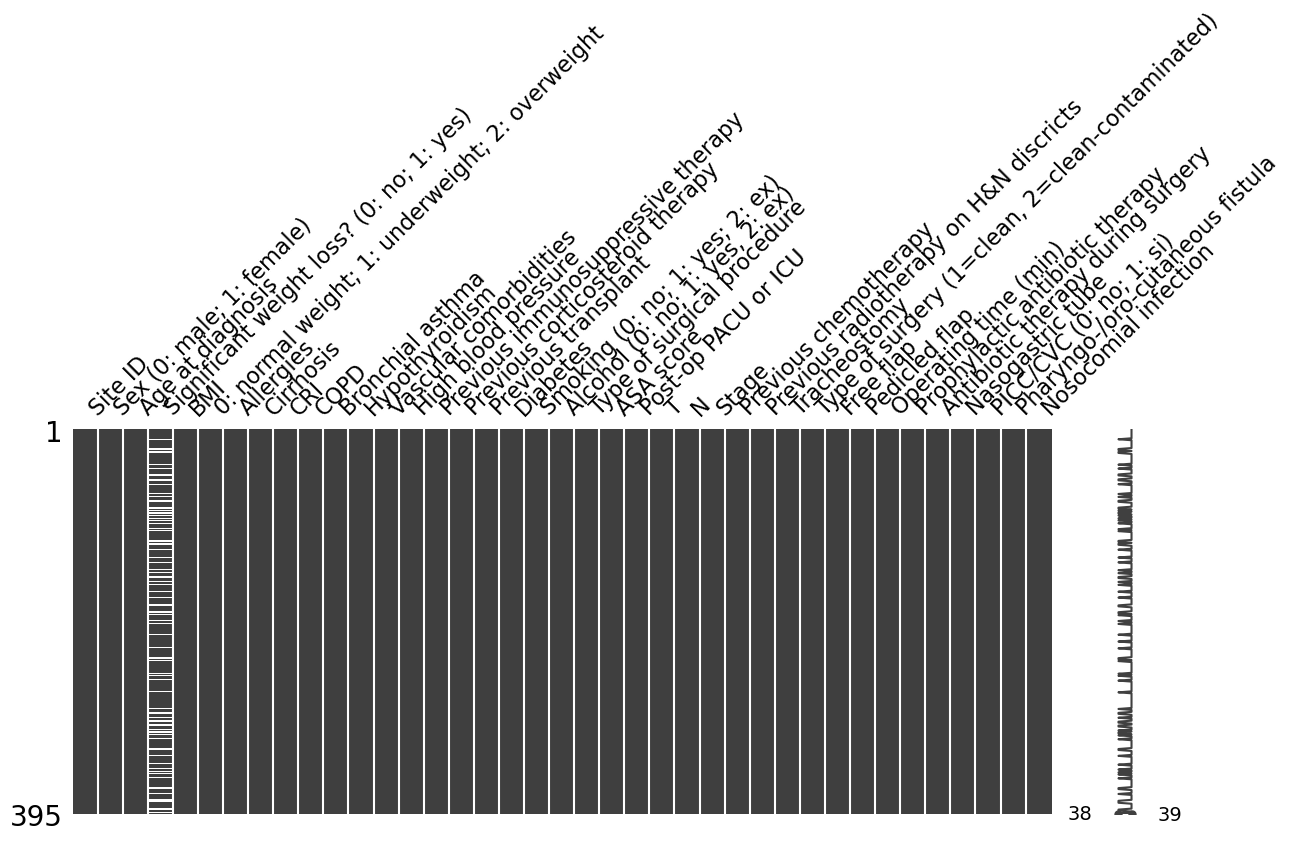

In [13]:
# 3.2 Missing Value Visualization in Train Split
import missingno as msno

print("\nMissing value patterns in training set:")
msno.matrix(train_df, figsize=(14, 5))
plt.show()

In [14]:
# 3.3 Imputation of missing values
from sklearn.impute import SimpleImputer

col = "Significant weight loss? (0: no; 1: yes)"

# Coerce to numeric, then to object for categorical imputation
train_df[col] = pd.to_numeric(train_df[col], errors='coerce').astype('object')
val_df[col] = pd.to_numeric(val_df[col], errors='coerce').astype('object')
test_df[col] = pd.to_numeric(test_df[col], errors='coerce').astype('object')

# Fit imputer on train, apply to all splits
imputer = SimpleImputer(strategy="constant", fill_value='-1')
train_df[[col]] = imputer.fit_transform(train_df[[col]])
val_df[[col]] = imputer.transform(val_df[[col]])
test_df[[col]] = imputer.transform(test_df[[col]])

# Ensure string type for OneHotEncoder compatibility
for split_df in [train_df, val_df, test_df]:
    split_df[col] = split_df[col].astype(str)


In [15]:
train_df.describe()

,Sex (0: male; 1: female),Age at diagnosis,BMI,Allergies,Cirrhosis,CRI,COPD,Bronchial asthma,Hypothyroidism,Vascular comorbidities,...,Tracheostomy,Free flap,Pedicled flap,Operating time (min),Prophylactic antibiotic therapy,Antibiotic therapy during surgery,Nasogastric tube,PICC/CVC (0: no; 1: si),Pharyngo-/oro-cutaneous fistula,Nosocomial infection
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,...,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,0.232911,64.693671,25.073818,0.202532,0.030380,0.037975,0.129114,0.015190,0.063291,0.192405,...,0.491139,0.075949,0.156962,228.868354,0.964557,0.898734,0.549367,0.425316,0.083544,0.243038
std,0.423222,12.726520,4.360074,0.402396,0.171848,0.191377,0.335751,0.122463,0.243795,0.394689,...,0.500555,0.265253,0.364226,154.471583,0.185131,0.302063,0.498188,0.495018,0.277054,0.429462
min,0.000000,19.000000,14.693878,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,57.000000,22.214276,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,100.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,67.000000,24.489796,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,210.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,73.000000,27.374882,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,315.500000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,98.000000,49.017892,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,840.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Section 4: Preprocessing Pipelines & Model Configuration

## 4.1 Feature-Target Data Organization & Pipeline Setup

Separate features and targets, identify numeric/categorical columns, and create preprocessing pipelines.

In [16]:
# ============================================================================
# SECTION 4: PREPROCESSING PIPELINES & MODEL CONFIGURATION
# ============================================================================

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

print("\n" + "=" * 80)
print("FEATURE ORGANIZATION & PREPROCESSING PIPELINE SETUP")
print("=" * 80)

# Separate features and targets
y_train = train_df[target_columns]
y_val = val_df[target_columns]
y_test = test_df[target_columns]

X_train = train_df.drop(columns=target_columns)
X_val = val_df.drop(columns=target_columns)
X_test = test_df.drop(columns=target_columns)

# Identify numeric and categorical features
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

print(f"Numeric features: {len(numeric_cols)}")
print(f"Categorical features: {len(categorical_cols)}")

preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])


FEATURE ORGANIZATION & PREPROCESSING PIPELINE SETUP
Numeric features: 30
Categorical features: 7


---


# Section 5: Model Training & Selection


## Complete Model Training Pipeline




### Overview


The workflow for binary classification consists of the following steps:



1. **GridSearchCV**: For each candidate model, hyperparameters are optimized using 5-fold cross-validation on the training set. The scoring metric is PR-AUC, which is robust to class imbalance.

2. **Threshold Tuning**: For each candidate, the best probability threshold is selected on the validation set to maximize the F1-score for the positive class.

3. **Model Selection**: The best model is chosen based on the highest F1-score on the validation set after threshold tuning.

4. **Final Evaluation**: The winning model is refit on the combined train+validation data, using its optimal threshold, and evaluated on the test set.



### Configuration


- **Scoring metric (CV)**: PR-AUC (average precision)

- **Threshold tuning**: F1-score on validation set, performed for all candidates

- **Winner selection**: Best F1-score on validation set after threshold tuning

- **Final model**: Refitted on train+validation, evaluated on test



### Models tried


- **LogisticRegression**

- **RandomForest**

- **XGBoost**

- **CatBoost**



This approach ensures robust model selection and threshold optimization, especially in the presence of class imbalance.

In [17]:
# 5.1 Install libraries
!pip install catboost

In [18]:
# 5.2 Import Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.base import clone
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, matthews_corrcoef,
    confusion_matrix, ConfusionMatrixDisplay
)
from scipy import sparse


In [19]:
# 5.3 Configure Cross-Validation Strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n" + "=" * 80)
print("CROSS-VALIDATION CONFIGURATION")
print("=" * 80)
print(f"Strategy: Stratified {cv.get_n_splits()}-Fold CV")


CROSS-VALIDATION CONFIGURATION
Strategy: Stratified 5-Fold CV


## 5.4 Configuration & Helper Functions

Set up evaluation metrics, configuration parameters, and helper functions for model training and threshold optimization.

In [20]:
import os

results_folder = "model_results"
plots_folder = os.path.join(results_folder, "plots")
results_tables_folder = os.path.join(results_folder, "results_tables")
os.makedirs(plots_folder, exist_ok=True)
os.makedirs(results_tables_folder, exist_ok=True)

print("\n" + "=" * 80)
print("CONFIGURATION & HELPER FUNCTIONS")
print("=" * 80)


# ==================== CONFIG ====================
SCORING_CV = "average_precision"     # per GridSearch
TUNE_THRESHOLD_BY = "f1_pos"         # per cercare la soglia
WINNER_SELECTED_BY = "f1_pos"        # per scegliere il modello finale

THRESHOLDS = np.linspace(0.05, 0.9, 91)
PROBA_THRESHOLD = 0.5
N_JOBS = -1
VERBOSE = 0

if "TARGETS_TO_RUN" not in globals():
    TARGETS_TO_RUN = list(target_columns)

print(f"CV Scoring metric: {SCORING_CV}")
print(f"Winner selection metric (VAL): {WINNER_SELECTED_BY}")
print(f"Threshold tuning metric (VAL): {TUNE_THRESHOLD_BY}")

def safe_filename(s):
    # Sostituisce caratteri problematici con underscore
    return "".join(c if c.isalnum() or c in "-_." else "_" for c in str(s))

# ==================== HELPERS ====================
def _eval_binary(y_true, y_prob, threshold=0.5):
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    y_pred = (y_prob >= threshold).astype(int)

    return {
        "threshold": float(threshold),
        "accuracy": accuracy_score(y_true, y_pred),
        "precision_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "recall_macro": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "f1_macro": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "precision_pos": precision_score(y_true, y_pred, pos_label=1, zero_division=0),
        "recall_pos": recall_score(y_true, y_pred, pos_label=1, zero_division=0),
        "f1_pos": f1_score(y_true, y_pred, pos_label=1, zero_division=0),
        "recall_neg": recall_score(y_true, y_pred, pos_label=0, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_prob),
        "pr_auc": average_precision_score(y_true, y_prob),
        "mcc": matthews_corrcoef(y_true, y_pred),
    }

def _threshold_key(m):
    return {
        "f1_pos": m["f1_pos"],
        "mcc": m["mcc"],
        "precision_pos": m["precision_pos"],
        "recall_pos": m["recall_pos"],
    }[TUNE_THRESHOLD_BY]

def _tune_threshold(y_true, y_prob, thresholds):
    best_t, best_val = 0.5, -np.inf
    best_metrics = None

    for t in thresholds:
        m = _eval_binary(y_true, y_prob, t)
        score = _threshold_key(m)
        if score > best_val:
            best_val = score
            best_t = t
            best_metrics = m

    return best_t, best_metrics

def _make_val_row(model, metrics, threshold, best_params, inner_score):
    return {
        "target": target,
        "model": model,
        "val_threshold": threshold,
        "inner_best_score": inner_score,
        **{f"val_{k}": v for k, v in metrics.items()},
        "best_params": best_params,
    }

def save_val_metrics_by_threshold(y_va, val_prob, name, target, thresholds, results_tables_folder):
    all_thr_metrics = []
    for t in thresholds:
        m = _eval_binary(y_va, val_prob, t)
        m['model'] = name
        m['threshold'] = t
        all_thr_metrics.append(m)
    df_thr_metrics = pd.DataFrame(all_thr_metrics)
    # Round float columns for better readability
    float_cols = df_thr_metrics.select_dtypes(include='float').columns
    df_thr_metrics[float_cols] = df_thr_metrics[float_cols].round(3)
    filename = f"{safe_filename(target)}_{safe_filename(name)}_val_metrics_by_threshold.csv"
    df_thr_metrics.to_csv(
        os.path.join(results_tables_folder, filename),
        index=False
    )

def run_target_verbose(target, candidates):
    y_tr = train_df[target].astype(int)
    y_va = val_df[target].astype(int)
    y_te = test_df[target].astype(int)

    fitted = []
    val_rows = []

    # ========== 1. Train + threshold tuning ==========
    for name, pipe, grid in candidates:
        print(f"\n--- {name} ---")

        gs = GridSearchCV(
            pipe,
            grid,
            scoring=SCORING_CV,
            cv=cv,
            n_jobs=N_JOBS,
            verbose=VERBOSE
        )
        gs.fit(X_train, y_tr)

        model = gs.best_estimator_
        val_prob = model.predict_proba(X_val)[:, 1]

        # threshold tuning
        best_thr, best_metrics = _tune_threshold(y_va, val_prob, THRESHOLDS)

        # metriche val set con threshold=0.5
        metrics_default = _eval_binary(y_va, val_prob, 0.5)

        print(
            f"VAL | thr={best_thr:.2f} | "
            f"F1_pos={best_metrics['f1_pos']:.3f} | "
            f"PR-AUC={best_metrics['pr_auc']:.3f}"
        )

        # Salva SOLO su file le metriche per ogni threshold
        save_val_metrics_by_threshold(y_va, val_prob, name, target, THRESHOLDS, results_tables_folder)

        val_rows.append(
            _make_val_row(
                name, metrics_default, 0.5,
                gs.best_params_, gs.best_score_
            )
        )
        val_rows.append(
            _make_val_row(
                name, best_metrics, best_thr,
                gs.best_params_, gs.best_score_
            )
        )

        fitted.append({
            "model": name,
            "estimator": model,
            "val_thr": best_thr,
        })

    # ========== 2. Select winner ==========
    df_val = pd.DataFrame(val_rows)
    rank_col = f"val_{WINNER_SELECTED_BY}"

    df_val['is_default_thr'] = (df_val['val_threshold'] == 0.5).astype(int)
    df_val = pd.concat([
        df_val[df_val['is_default_thr'] == 1].sort_values(rank_col, ascending=False),
        df_val[df_val['is_default_thr'] == 0].sort_values(rank_col, ascending=False)
    ], ignore_index=True).drop(columns=['is_default_thr'])

    # Save the summary table that appears in the output
    df_val.to_csv(
        os.path.join(results_tables_folder, f"{safe_filename(target)}_val_summary.csv"),
        index=False
    )

    display(df_val)

    winner_row = df_val.loc[df_val[rank_col].idxmax()]
    winner_name = winner_row["model"]
    winner_thr = winner_row["val_threshold"]

    winner = next(x for x in fitted if x["model"] == winner_name)

    print(
        f"\n🏆 WINNER: {winner_name} | "
        f"{WINNER_SELECTED_BY}={winner_row[rank_col]:.3f}"
    )

    # ========== 3. Refit on TRAIN+VAL ==========
    final_model = clone(winner["estimator"])
    final_model.fit(
        pd.concat([X_train, X_val]),
        pd.concat([y_tr, y_va])
    )

    # ========== 4. Test ==========
    test_prob = final_model.predict_proba(X_test)[:, 1]
    test_metrics = _eval_binary(y_te, test_prob, winner_thr)

    y_pred_te = (np.asarray(test_prob) >= float(winner_thr)).astype(int)
    te_cm = confusion_matrix(np.asarray(y_te).astype(int), y_pred_te)

    print("\nTEST RESULTS:")
    for k, v in test_metrics.items():
        print(f"{k:15s}: {v:.4f}")
    print("TEST Confusion Matrix:")
    print(te_cm)

    # Plot confusion matrix for test set
    ConfusionMatrixDisplay(te_cm).plot()
    plt.title(f"{winner_name} - Test Confusion Matrix (thr={winner_thr:.2f})")
    plt.show()

    return df_val, winner_row, final_model, winner_thr, test_metrics, te_cm


CONFIGURATION & HELPER FUNCTIONS
CV Scoring metric: average_precision
Winner selection metric (VAL): f1_pos
Threshold tuning metric (VAL): f1_pos


In [21]:
# ==================== MAKE MODELS & GRID ====================
def make_models_and_grids(preprocessor, y_tr):
    # Calcolo automatico dei pesi per classi sbilanciate
    N_pos = sum(y_tr == 1)
    N_neg = sum(y_tr == 0)
    scale_pos_weight = N_neg / max(N_pos, 1)  # evita divisione per 0

    candidates = []

    # LogisticRegression e RandomForest con class_weight bilanciato
    candidates.append((
        "LogisticRegression",
        ImbPipeline([("preprocess", preprocessor), ("clf", LogisticRegression())]),
        [
            {
                "clf__solver": ["lbfgs"], "clf__penalty": ["l2"], "clf__C": [0.001, 0.01, 0.1, 1, 10, 100],
                "clf__class_weight": ["balanced"], "clf__max_iter": [2000],
            },
            {
                "clf__solver": ["liblinear"], "clf__penalty": ["l2"], "clf__C": [0.001, 0.01, 0.1, 1, 10, 100],
                "clf__class_weight": ["balanced"], "clf__max_iter": [2000],
            },
        ],
    ))

    candidates.append((
        "RandomForest",
        ImbPipeline([("preprocess", preprocessor), ("clf", RandomForestClassifier(random_state=42))]),
        {
            "clf__n_estimators": [100, 150],
            "clf__max_depth": [3, 5, None],
            "clf__min_samples_split": [5, 10],
            "clf__min_samples_leaf": [3, 5],
            "clf__max_features": ["sqrt"],
            "clf__class_weight": ["balanced"],
        },
    ))

    # XGBoost con scale_pos_weight
    candidates.append((
        "XGBoost",
        ImbPipeline([("preprocess", preprocessor), ("clf", XGBClassifier(
            eval_metric="logloss", random_state=42, n_jobs=-1, scale_pos_weight=scale_pos_weight
        ))]),
        {
            "clf__n_estimators": [150, 300],
            "clf__learning_rate": [0.05],
            "clf__max_depth": [3, 4],
            "clf__min_child_weight": [5, 10],
            "clf__subsample": [0.8],
            "clf__colsample_bytree": [0.8],
            "clf__reg_alpha": [0, 0.1],
            "clf__reg_lambda": [5, 10],
        },
    ))

    # CatBoost con auto_class_weights
    candidates.append((
        "CatBoost",
        ImbPipeline([("preprocess", preprocessor), ("clf", CatBoostClassifier(verbose=0, random_state=42))]),
        {
            "clf__depth": [4, 6],
            "clf__learning_rate": [0.03, 0.1],
            "clf__iterations": [300, 800],
            "clf__l2_leaf_reg": [3, 10],
            "clf__bagging_temperature": [0, 1],
            "clf__auto_class_weights": ["SqrtBalanced"],
        },
    ))

    return candidates



================= TARGET: Pharyngo-/oro-cutaneous fistula =================

--- LogisticRegression ---
VAL | thr=0.58 | F1_pos=0.500 | PR-AUC=0.288

--- RandomForest ---
VAL | thr=0.42 | F1_pos=0.556 | PR-AUC=0.474

--- XGBoost ---
VAL | thr=0.68 | F1_pos=0.500 | PR-AUC=0.449

--- CatBoost ---
VAL | thr=0.12 | F1_pos=0.444 | PR-AUC=0.372


,target,model,val_threshold,inner_best_score,val_accuracy,val_precision_macro,val_recall_macro,val_f1_macro,val_precision_pos,val_recall_pos,val_f1_pos,val_recall_neg,val_roc_auc,val_pr_auc,val_mcc,best_params
0,Pharyngo-/oro-cutaneous fistula,XGBoost,0.500000,0.275371,0.823529,0.642308,0.838828,0.669775,0.300000,0.857143,0.444444,0.820513,0.897436,0.448709,0.439171,"{'clf__colsample_bytree': 0.8, 'clf__learning_..."
1,Pharyngo-/oro-cutaneous fistula,RandomForest,0.500000,0.301854,0.905882,0.688645,0.688645,0.688645,0.428571,0.428571,0.428571,0.948718,0.890110,0.473791,0.377289,"{'clf__class_weight': 'balanced', 'clf__max_de..."
2,Pharyngo-/oro-cutaneous fistula,CatBoost,0.500000,0.381909,0.894118,0.635021,0.617216,0.625184,0.333333,0.285714,0.307692,0.948718,0.827839,0.371551,0.251608,"{'clf__auto_class_weights': 'SqrtBalanced', 'c..."
3,Pharyngo-/oro-cutaneous fistula,LogisticRegression,0.500000,0.333668,0.635294,0.573129,0.736264,0.517488,0.166667,0.857143,0.279070,0.615385,0.846154,0.288356,0.262890,"{'clf__C': 0.001, 'clf__class_weight': 'balanc..."
4,Pharyngo-/oro-cutaneous fistula,RandomForest,0.418333,0.301854,0.905882,0.713759,0.818681,0.751462,0.454545,0.714286,0.555556,0.923077,0.890110,0.473791,0.522000,"{'clf__class_weight': 'balanced', 'clf__max_de..."
5,Pharyngo-/oro-cutaneous fistula,LogisticRegression,0.578889,0.333668,0.882353,0.678419,0.805861,0.716667,0.384615,0.714286,0.500000,0.897436,0.846154,0.288356,0.467210,"{'clf__C': 0.001, 'clf__class_weight': 'balanc..."
6,Pharyngo-/oro-cutaneous fistula,XGBoost,0.682778,0.275371,0.882353,0.678419,0.805861,0.716667,0.384615,0.714286,0.500000,0.897436,0.897436,0.448709,0.467210,"{'clf__colsample_bytree': 0.8, 'clf__learning_..."
7,Pharyngo-/oro-cutaneous fistula,CatBoost,0.116111,0.381909,0.882353,0.661548,0.740842,0.689327,0.363636,0.571429,0.444444,0.910256,0.827839,0.371551,0.394500,"{'clf__auto_class_weights': 'SqrtBalanced', 'c..."



🏆 WINNER: RandomForest | f1_pos=0.556

TEST RESULTS:
threshold      : 0.4183
accuracy       : 0.8706
precision_macro: 0.6803
recall_macro   : 0.8645
f1_macro       : 0.7235
precision_pos  : 0.3750
recall_pos     : 0.8571
f1_pos         : 0.5217
recall_neg     : 0.8718
roc_auc        : 0.8736
pr_auc         : 0.3305
mcc            : 0.5126
TEST Confusion Matrix:
[[68 10]
 [ 1  6]]


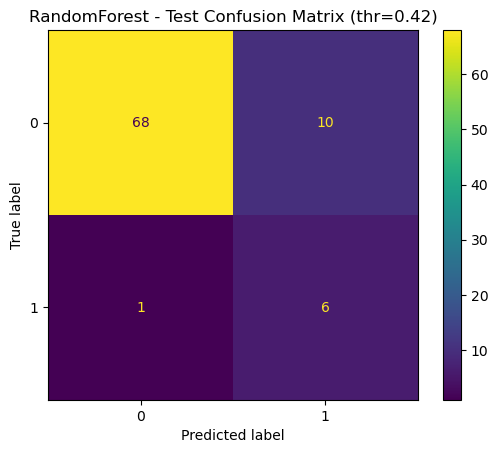

,target,model,val_threshold,inner_best_score,val_accuracy,val_precision_macro,val_recall_macro,val_f1_macro,val_precision_pos,val_recall_pos,val_f1_pos,val_recall_neg,val_roc_auc,val_pr_auc,val_mcc,best_params
0,Pharyngo-/oro-cutaneous fistula,XGBoost,0.500000,0.275371,0.823529,0.642308,0.838828,0.669775,0.300000,0.857143,0.444444,0.820513,0.897436,0.448709,0.439171,"{'clf__colsample_bytree': 0.8, 'clf__learning_..."
1,Pharyngo-/oro-cutaneous fistula,RandomForest,0.500000,0.301854,0.905882,0.688645,0.688645,0.688645,0.428571,0.428571,0.428571,0.948718,0.890110,0.473791,0.377289,"{'clf__class_weight': 'balanced', 'clf__max_de..."
2,Pharyngo-/oro-cutaneous fistula,CatBoost,0.500000,0.381909,0.894118,0.635021,0.617216,0.625184,0.333333,0.285714,0.307692,0.948718,0.827839,0.371551,0.251608,"{'clf__auto_class_weights': 'SqrtBalanced', 'c..."
3,Pharyngo-/oro-cutaneous fistula,LogisticRegression,0.500000,0.333668,0.635294,0.573129,0.736264,0.517488,0.166667,0.857143,0.279070,0.615385,0.846154,0.288356,0.262890,"{'clf__C': 0.001, 'clf__class_weight': 'balanc..."
4,Pharyngo-/oro-cutaneous fistula,RandomForest,0.418333,0.301854,0.905882,0.713759,0.818681,0.751462,0.454545,0.714286,0.555556,0.923077,0.890110,0.473791,0.522000,"{'clf__class_weight': 'balanced', 'clf__max_de..."
5,Pharyngo-/oro-cutaneous fistula,LogisticRegression,0.578889,0.333668,0.882353,0.678419,0.805861,0.716667,0.384615,0.714286,0.500000,0.897436,0.846154,0.288356,0.467210,"{'clf__C': 0.001, 'clf__class_weight': 'balanc..."
6,Pharyngo-/oro-cutaneous fistula,XGBoost,0.682778,0.275371,0.882353,0.678419,0.805861,0.716667,0.384615,0.714286,0.500000,0.897436,0.897436,0.448709,0.467210,"{'clf__colsample_bytree': 0.8, 'clf__learning_..."
7,Pharyngo-/oro-cutaneous fistula,CatBoost,0.116111,0.381909,0.882353,0.661548,0.740842,0.689327,0.363636,0.571429,0.444444,0.910256,0.827839,0.371551,0.394500,"{'clf__auto_class_weights': 'SqrtBalanced', 'c..."




================= TARGET: Nosocomial infection =================

--- LogisticRegression ---
VAL | thr=0.48 | F1_pos=0.630 | PR-AUC=0.620

--- RandomForest ---
VAL | thr=0.61 | F1_pos=0.636 | PR-AUC=0.625

--- XGBoost ---
VAL | thr=0.42 | F1_pos=0.615 | PR-AUC=0.608

--- CatBoost ---
VAL | thr=0.38 | F1_pos=0.653 | PR-AUC=0.671


,target,model,val_threshold,inner_best_score,val_accuracy,val_precision_macro,val_recall_macro,val_f1_macro,val_precision_pos,val_recall_pos,val_f1_pos,val_recall_neg,val_roc_auc,val_pr_auc,val_mcc,best_params
0,Nosocomial infection,RandomForest,0.500000,0.559080,0.752941,0.712857,0.786538,0.717787,0.485714,0.85,0.618182,0.723077,0.861538,0.625406,0.493930,"{'clf__class_weight': 'balanced', 'clf__max_de..."
1,Nosocomial infection,CatBoost,0.500000,0.537475,0.788235,0.718383,0.757692,0.731767,0.538462,0.70,0.608696,0.815385,0.866154,0.671126,0.474450,"{'clf__auto_class_weights': 'SqrtBalanced', 'c..."
2,Nosocomial infection,LogisticRegression,0.500000,0.571313,0.752941,0.703963,0.769231,0.712143,0.484848,0.80,0.603774,0.738462,0.845385,0.619874,0.468671,"{'clf__C': 0.001, 'clf__class_weight': 'balanc..."
3,Nosocomial infection,XGBoost,0.500000,0.551266,0.776471,0.707535,0.750000,0.720637,0.518519,0.70,0.595745,0.800000,0.838462,0.608145,0.455560,"{'clf__colsample_bytree': 0.8, 'clf__learning_..."
4,Nosocomial infection,CatBoost,0.380556,0.537475,0.800000,0.740148,0.800000,0.756283,0.551724,0.80,0.653061,0.800000,0.866154,0.671126,0.536822,"{'clf__auto_class_weights': 'SqrtBalanced', 'c..."
5,Nosocomial infection,RandomForest,0.607222,0.559080,0.811765,0.742486,0.773077,0.754690,0.583333,0.70,0.636364,0.846154,0.861538,0.625406,0.514655,"{'clf__class_weight': 'balanced', 'clf__max_de..."
6,Nosocomial infection,LogisticRegression,0.484444,0.571313,0.764706,0.720588,0.794231,0.728608,0.500000,0.85,0.629630,0.738462,0.845385,0.619874,0.509525,"{'clf__C': 0.001, 'clf__class_weight': 'balanc..."
7,Nosocomial infection,XGBoost,0.418333,0.551266,0.764706,0.712264,0.776923,0.722947,0.500000,0.80,0.615385,0.753846,0.838462,0.608145,0.484895,"{'clf__colsample_bytree': 0.8, 'clf__learning_..."



🏆 WINNER: CatBoost | f1_pos=0.653

TEST RESULTS:
threshold      : 0.3806
accuracy       : 0.8000
precision_macro: 0.7419
recall_macro   : 0.7872
f1_macro       : 0.7563
precision_pos  : 0.5714
recall_pos     : 0.7619
f1_pos         : 0.6531
recall_neg     : 0.8125
roc_auc        : 0.8036
pr_auc         : 0.6025
mcc            : 0.5271
TEST Confusion Matrix:
[[52 12]
 [ 5 16]]


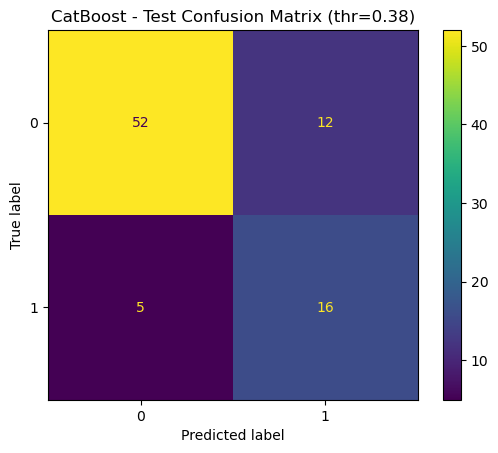

,target,model,val_threshold,inner_best_score,val_accuracy,val_precision_macro,val_recall_macro,val_f1_macro,val_precision_pos,val_recall_pos,val_f1_pos,val_recall_neg,val_roc_auc,val_pr_auc,val_mcc,best_params
0,Nosocomial infection,RandomForest,0.500000,0.559080,0.752941,0.712857,0.786538,0.717787,0.485714,0.85,0.618182,0.723077,0.861538,0.625406,0.493930,"{'clf__class_weight': 'balanced', 'clf__max_de..."
1,Nosocomial infection,CatBoost,0.500000,0.537475,0.788235,0.718383,0.757692,0.731767,0.538462,0.70,0.608696,0.815385,0.866154,0.671126,0.474450,"{'clf__auto_class_weights': 'SqrtBalanced', 'c..."
2,Nosocomial infection,LogisticRegression,0.500000,0.571313,0.752941,0.703963,0.769231,0.712143,0.484848,0.80,0.603774,0.738462,0.845385,0.619874,0.468671,"{'clf__C': 0.001, 'clf__class_weight': 'balanc..."
3,Nosocomial infection,XGBoost,0.500000,0.551266,0.776471,0.707535,0.750000,0.720637,0.518519,0.70,0.595745,0.800000,0.838462,0.608145,0.455560,"{'clf__colsample_bytree': 0.8, 'clf__learning_..."
4,Nosocomial infection,CatBoost,0.380556,0.537475,0.800000,0.740148,0.800000,0.756283,0.551724,0.80,0.653061,0.800000,0.866154,0.671126,0.536822,"{'clf__auto_class_weights': 'SqrtBalanced', 'c..."
5,Nosocomial infection,RandomForest,0.607222,0.559080,0.811765,0.742486,0.773077,0.754690,0.583333,0.70,0.636364,0.846154,0.861538,0.625406,0.514655,"{'clf__class_weight': 'balanced', 'clf__max_de..."
6,Nosocomial infection,LogisticRegression,0.484444,0.571313,0.764706,0.720588,0.794231,0.728608,0.500000,0.85,0.629630,0.738462,0.845385,0.619874,0.509525,"{'clf__C': 0.001, 'clf__class_weight': 'balanc..."
7,Nosocomial infection,XGBoost,0.418333,0.551266,0.764706,0.712264,0.776923,0.722947,0.500000,0.80,0.615385,0.753846,0.838462,0.608145,0.484895,"{'clf__colsample_bytree': 0.8, 'clf__learning_..."



✓ Training complete! Results saved to results_tables_folder and best_estimators_by_target


In [22]:
# ==================== EXECUTION ====================
val_all_models = []
val_best_rows = []
test_best_rows = []
best_estimators_by_target = {}
best_thresholds_by_target = {}
best_params_by_target = {}

for target in TARGETS_TO_RUN:
    print(f"\n\n================= TARGET: {target} =================")

    # Compute y_train for this target
    y_tr = train_df[target].astype(int)

    # Create models with appropriate class weights for imbalance
    candidates = make_models_and_grids(preprocessor, y_tr)

    # Full run per target: fit, winner selection, threshold tuning, test
    df_models_val, best_row, final_est, best_thr, test_metrics, te_cm = run_target_verbose(target, candidates)

    # Visualizza la tabella riassuntiva per ogni target
    display(df_models_val)

    val_all_models.append(df_models_val)
    val_best_rows.append(best_row)

    test_best_rows.append({
        "target": target,
        "best_model": best_row["model"],
        "threshold": float(best_thr),
        "confusion_matrix": te_cm.tolist(),
        **test_metrics,
    })

    best_estimators_by_target[target] = final_est
    best_thresholds_by_target[target] = float(best_thr)
    best_params_by_target[target] = best_row.get("best_params", {})

# Create final DataFrames
val_all_models_df = pd.concat(val_all_models, axis=0, ignore_index=True)
val_best_df = pd.DataFrame(val_best_rows)
test_best_df = pd.DataFrame(test_best_rows)

# Salva i risultati tabellari nella cartella results_tables_folder
val_all_models_df.to_csv(os.path.join(results_tables_folder, "val_all_models.csv"), index=False)
val_best_df.to_csv(os.path.join(results_tables_folder, "val_best_summary.csv"), index=False)
test_best_df.to_csv(os.path.join(results_tables_folder, "test_best_summary.csv"), index=False)

print("\n✓ Training complete! Results saved to results_tables_folder and best_estimators_by_target")

# Interpletability Section

## SHAP Analysis and Interpretation

We compute SHAP values on the full test set to understand which features drive model predictions. The analysis combines three complementary visualizations: bar plots (feature importance), beeswarm plots (individual patient effects), and dependence plots (feature-outcome relationships).

---

## How to Read These Plots

**Bar Plot (Top 15 Features):**  
This plot ranks features by their average impact on the model’s predictions. Each bar represents the mean absolute SHAP value for a feature across all samples. Longer bars indicate features that have a stronger overall influence on the model’s output.

**Beeswarm Plot (Patient-Level Effects):**  
This plot shows how each feature influences the prediction for every individual patient in the test set.
- **Horizontal axis:** SHAP value (effect on prediction)
  - Left = decreases predicted probability
  - Right = increases predicted probability
- **Vertical axis:** Features ordered by importance (top = most important)
- **Color coding:**
  - For categorical features: **Red** = present, **Blue** = absent
  - For numerical features: **Blue** = low values, **Red** = high values

The beeswarm plot visualizes both the overall importance of each feature and the variability of its effect across patients.

**Dependence Plot:**  
This plot shows the relationship between a single feature’s value and its SHAP value (effect on prediction), highlighting how the feature’s effect varies across its range and in interaction with other features. It helps to understand whether the effect is linear, monotonic, or interacts with other variables.

---

*Note: SHAP values show what the model learned from the data. The beeswarm plot is particularly useful because it displays both aggregate importance (vertical ordering) and individual variability (dot scatter) for each feature.*

In [23]:
!pip install shap


CALCULATING SHAP VALUES - TOP 15 FEATURES (Full Test Set)

SHAP Analysis: Pharyngo-/oro-cutaneous fistula | Model: RandomForest
  Background (train+val) shape: (480, 79)
  Test set shape: (85, 79)
  Creating SHAP explainer for RandomForestClassifier...
  ✓ SHAP values calculated for 85 test samples (shape: (85, 79))


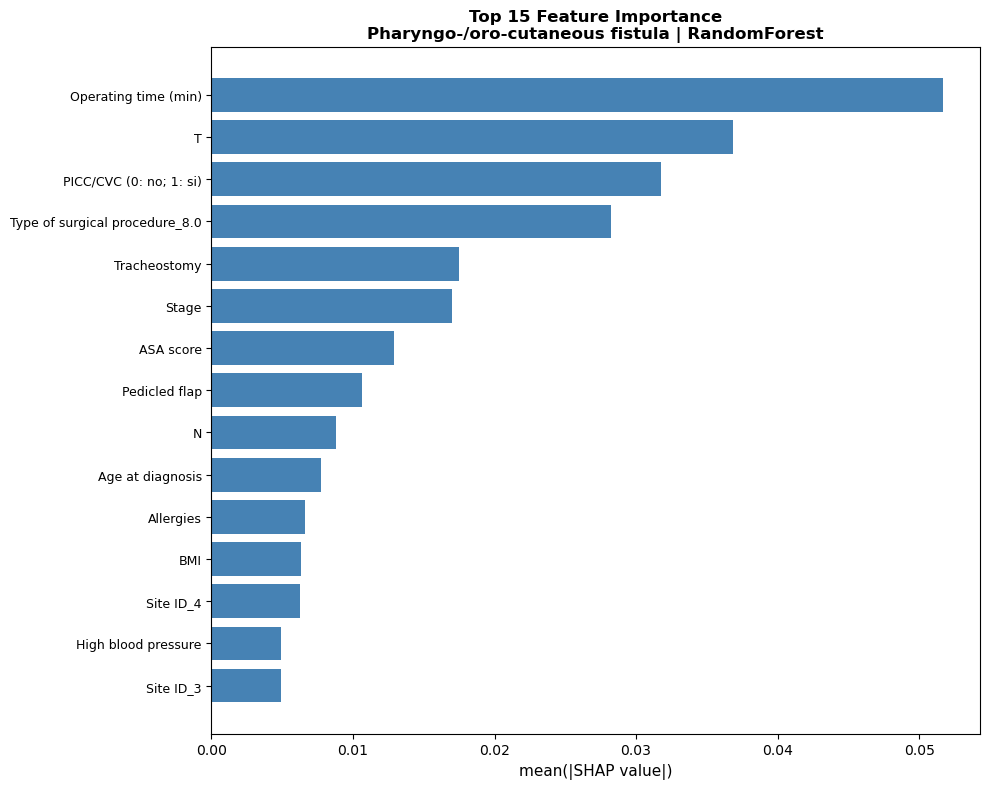

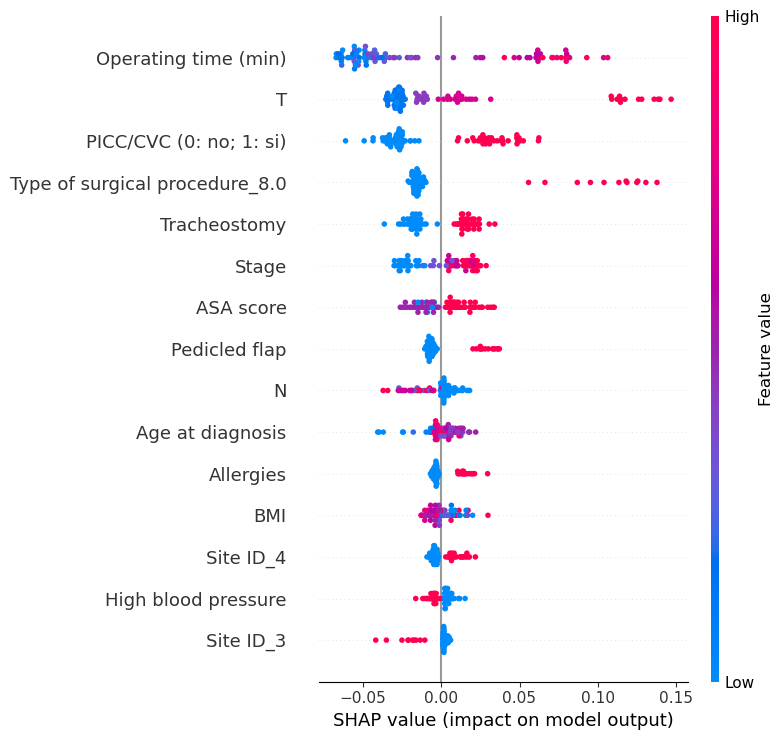

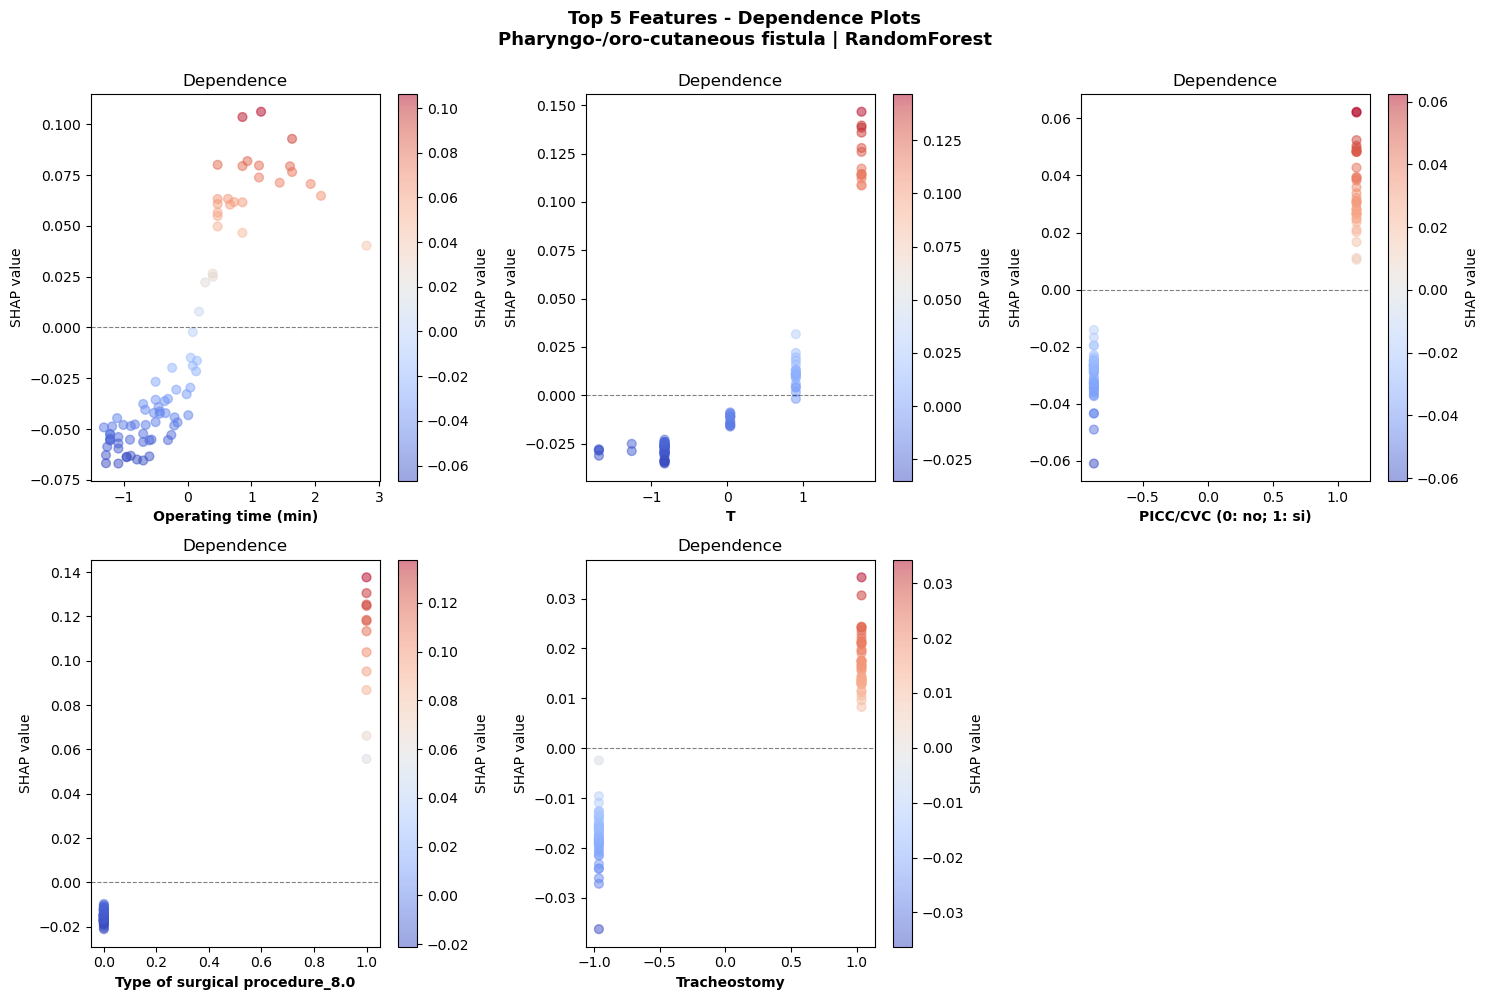

  ✓ SHAP plots generated and saved successfully


SHAP Analysis: Nosocomial infection | Model: CatBoost
  Background (train+val) shape: (480, 79)
  Test set shape: (85, 79)
  Creating SHAP explainer for CatBoostClassifier...
  ✓ SHAP values calculated for 85 test samples (shape: (85, 79))


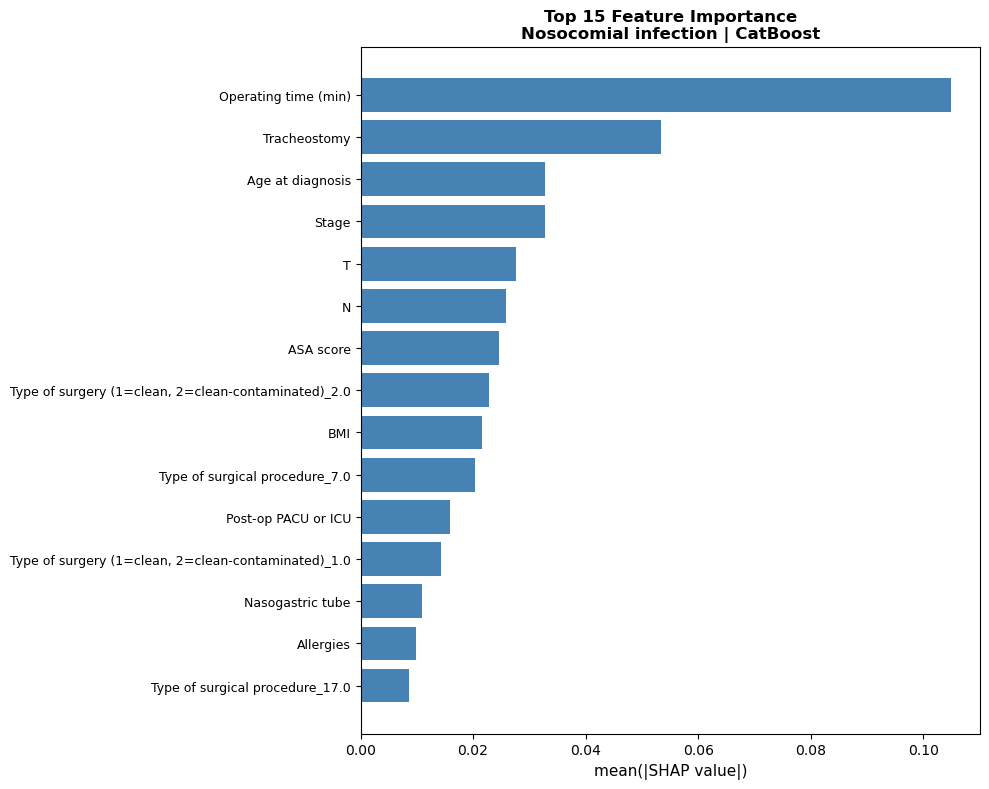

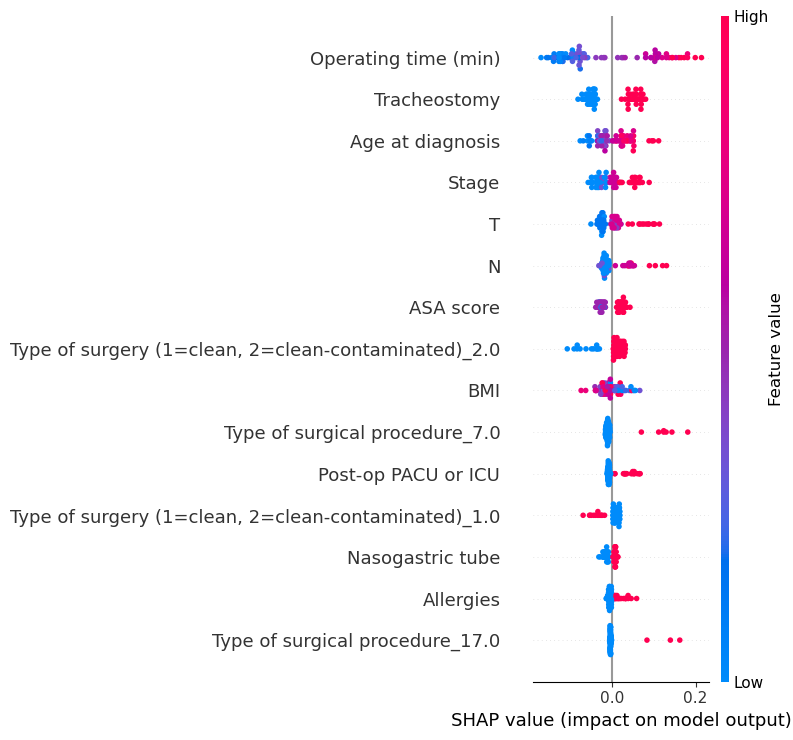

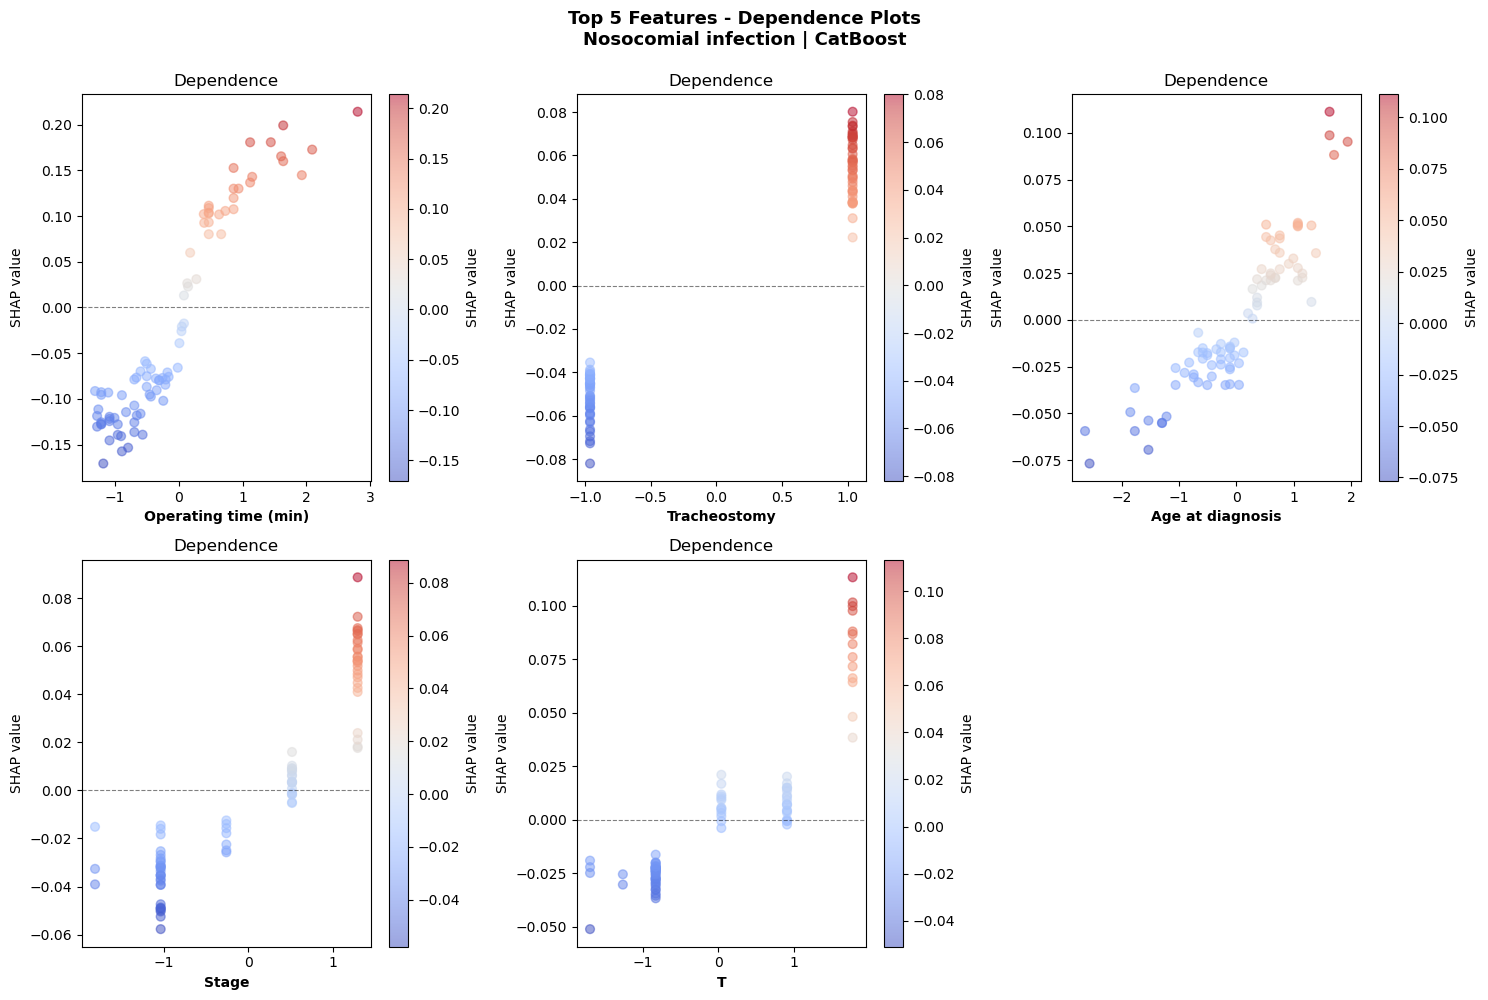

  ✓ SHAP plots generated and saved successfully

SHAP analysis complete for all targets!


In [24]:
import subprocess
import sys

# Install SHAP if not present
try:
    import shap
except ImportError:
    print("Installing SHAP library...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap", "-q"])
    import shap

def _to_dense(X):
    """Convert sparse matrix to dense array if needed"""
    if hasattr(X, 'toarray'):
        return X.toarray()
    return np.asarray(X)

def _clean_feature_names(feature_names_raw):
    """Remove num_ and cat_ prefixes from feature names"""
    cleaned = []
    for name in feature_names_raw:
        if name.startswith("num__"):
            cleaned.append(name[5:])
        elif name.startswith("cat__"):
            cleaned.append(name[5:])
        else:
            cleaned.append(name)
    return cleaned

print("\n" + "="*80)
print("CALCULATING SHAP VALUES - TOP 15 FEATURES (Full Test Set)")
print("="*80)

for target in TARGETS_TO_RUN:
    if target not in best_estimators_by_target:
        continue

    pipe = best_estimators_by_target[target]
    if hasattr(val_best_df, 'columns') and "target" in val_best_df.columns:
        model_name = val_best_df.loc[val_best_df["target"] == target, "model"].iloc[0]
    else:
        model_name = type(pipe.named_steps["clf"]).__name__

    print(f"\n{'='*60}")
    print(f"SHAP Analysis: {target} | Model: {model_name}")
    print(f"{'='*60}")

    # Preprocessor e modello
    preprocessor = pipe.named_steps["preprocess"]
    clf = pipe.named_steps["clf"]
    model_type = type(clf).__name__

    # Trasforma train+val (background) e test set
    X_train_val_array = _to_dense(preprocessor.transform(pd.concat([X_train, X_val])))
    X_test_array = _to_dense(preprocessor.transform(X_test))
    
    print(f"  Background (train+val) shape: {X_train_val_array.shape}")
    print(f"  Test set shape: {X_test_array.shape}")

    # Feature names - CLEAN VERSION WITHOUT PREFIXES
    try:
        feature_names_raw = list(preprocessor.get_feature_names_out())
        feature_names = _clean_feature_names(feature_names_raw)
    except:
        feature_names = [f"f{i}" for i in range(X_test_array.shape[1])]

    X_background = X_train_val_array  # uso tutto il train+val come background

    # ===== SHAP Explainer =====
    print(f"  Creating SHAP explainer for {model_type}...")
    try:
        if model_type in ["RandomForestClassifier", "CatBoostClassifier"]:
            explainer = shap.TreeExplainer(clf, data=X_background, model_output='probability')
            shap_values = explainer.shap_values(X_test_array)
            if isinstance(shap_values, list):
                shap_values = shap_values[1]  # positive class
            elif hasattr(shap_values, 'ndim') and shap_values.ndim == 3:
                shap_values = shap_values[:, :, 1]
        elif model_type == "XGBClassifier":
            explainer = shap.TreeExplainer(clf, data=X_background)
            shap_values = explainer.shap_values(X_test_array)
        elif model_type == "LogisticRegression":
            explainer = shap.LinearExplainer(clf, X_background, feature_perturbation="interventional")
            shap_values = explainer.shap_values(X_test_array)
        else:
            explainer = shap.KernelExplainer(clf.predict_proba, X_background)
            shap_values = explainer.shap_values(X_test_array)
            if isinstance(shap_values, list):
                shap_values = shap_values[1]

        if shap_values.ndim == 1:
            shap_values = shap_values.reshape(-1, 1)

        print(f"  ✓ SHAP values calculated for {X_test_array.shape[0]} test samples (shape: {shap_values.shape})")

        # ===== Bar plot Top 15 =====
        mean_abs_shap = np.abs(shap_values).mean(axis=0)
        top_15_idx = np.argsort(mean_abs_shap)[-15:][::-1]
        top_15_names = [feature_names[i] for i in top_15_idx]
        top_15_values = mean_abs_shap[top_15_idx]

        plt.figure(figsize=(10, 8))
        plt.barh(range(len(top_15_names)), top_15_values, color='steelblue')
        plt.yticks(range(len(top_15_names)), top_15_names, fontsize=9)
        plt.xlabel("mean(|SHAP value|)", fontsize=11)
        plt.title(f"Top 15 Feature Importance\n{target} | {model_name}", fontweight='bold', fontsize=12)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig(os.path.join(plots_folder, f"{safe_filename(target)}_{safe_filename(model_name)}_shap_bar.png"), dpi=300, bbox_inches='tight')
        plt.show()

        # ===== Beeswarm plot =====
        shap_values_top15 = shap_values[:, top_15_idx]
        X_test_array_top15 = X_test_array[:, top_15_idx]
        shap.summary_plot(shap_values_top15, X_test_array_top15,
                          feature_names=top_15_names, plot_type="dot", show=False)
        plt.tight_layout()
        plt.savefig(os.path.join(plots_folder, f"{safe_filename(target)}_{safe_filename(model_name)}_shap_beeswarm.png"), dpi=300, bbox_inches='tight')
        plt.show()
        
        # ===== Dependence plots per top 5 =====
        top_5_idx = top_15_idx[:5]
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()
        for idx, feat_idx in enumerate(top_5_idx):
            ax = axes[idx]
            shap_vals = shap_values[:, feat_idx]
            feat_vals = X_test_array[:, feat_idx]
            scatter = ax.scatter(feat_vals, shap_vals, alpha=0.5, c=shap_vals, cmap="coolwarm", s=40)
            ax.axhline(0, color='k', linestyle='--', lw=0.8, alpha=0.5)
            ax.set_xlabel(feature_names[feat_idx], fontsize=10, fontweight='bold')
            ax.set_ylabel("SHAP value", fontsize=10)
            ax.set_title("Dependence")
            fig.colorbar(scatter, ax=ax, label='SHAP value')
        axes[-1].axis('off')
        plt.suptitle(f"Top 5 Features - Dependence Plots\n{target} | {model_name}",
                     fontweight='bold', fontsize=13, y=0.995)
        plt.tight_layout()
        plt.savefig(os.path.join(plots_folder, f"{safe_filename(target)}_{safe_filename(model_name)}_shap_dependence.png"), dpi=300, bbox_inches='tight')
        plt.show()

        print("  ✓ SHAP plots generated and saved successfully\n")

    except Exception as e:
        print(f"  ✗ Error: {str(e)}")
        import traceback
        traceback.print_exc()
        continue

print("="*80)
print("SHAP analysis complete for all targets!")
print("="*80)

**Main Findings**

**Fistula:**  
- **Operating time** is the most influential feature: longer surgeries are associated with higher predicted probability of fistula.
- Other important features include **T-stage**, **PICC/CVC**, **procedure type**, and **Stage**.
- The effect of these features is consistent across most patients, as shown by the beeswarm plot.

**Nosocomial Infection:**  
- **Operating time** again emerges as the strongest predictor.
- **Tracheostomy**, **Stage**, **Age**, and **N-stage** are also highly relevant.
- For some features, such as age, the effect varies more between patients, indicating clinical heterogeneity.

**Clinical Heterogeneity**

- The spread of SHAP values for features like age and stage shows that patients with similar values can have different predicted risks, depending on their overall clinical profile.
- This highlights the importance of personalized risk prediction.

**Key Takeaways**

1. **Operating time** is the most actionable and influential predictor for both complications.
2. **TNM staging** (T, N, Stage) reflects disease severity and consistently impacts risk.
3. **Procedural indicators** (Tracheostomy, PICC/CVC) are linked to surgical complexity and post-operative risk.
4. **Predictions are patient-specific:** identical feature values can have different effects depending on the patient’s profile.

## Signed Effect (Custom Counterfactual Method)

## What is the Signed Effect?

The **Signed Effect** quantifies how much the model’s predicted probability of complication changes when a single feature is increased from a low to a high value, keeping all other features fixed.  
- **Red bars**: Feature increases the predicted probability (Δ > 0)
- **Green bars**: Feature decreases the predicted probability (Δ < 0)

**How is it calculated?**  
For each feature, we:
1. Take the test set (subsampled for stability)
2. For each feature, create two scenarios:
   - **Low**: Set feature to 0 (if binary) or 1st quartile (Q1) if continuous
   - **High**: Set feature to 1 (if binary) or 3rd quartile (Q3) if continuous
3. Predict the average **model probability of complication** in both scenarios
4. Compute the difference:  
   **Δ = P_high − P_low**


---

## Why include Signed Effect (vs SHAP)?

**SHAP** is powerful but complex, showing how each feature contributes to each individual prediction (requires understanding Shapley values).  
**Signed Effect** is:
- **Simple**: Directly answers "Does this feature increase or decrease the model’s predicted probability, and by how much?"
- **Actionable**: Red = increases predicted probability, Green = decreases predicted probability
- **Interpretable**: More understandable by the stakeholders

| Aspect              | SHAP                                      | Signed Effect                                 |
|---------------------|-------------------------------------------|-----------------------------------------------|
| Interpretability    | Per-patient, technical                    | Population-level, intuitive                   |
| Main insight        | Individual variability                    | Average effect and direction                  |
| Clinical question   | "How much does this feature contribute?"  | "If I increase this, does the predicted probability go up or down?"|

**In summary:**  
- Use **Signed Effect** for quick, actionable insights (what to optimize)
- Use **SHAP** for understanding patient-level heterogeneity

*Note: Signed Effect is a custom, counterfactual-based method designed for clinical communication. Values are not causal effects, but show how the model’s predicted probability changes when features are varied.*


================= SIGNED FEATURE EFFECT =================

=== SIGNED EFFECT Δ mean P(class=1) - target: Pharyngo-/oro-cutaneous fistula | model: RandomForest ===


,feature,delta_mean_p1,direction
0,Operating time (min),0.118065,+
1,Type of surgical procedure 8.0,0.116849,+
2,PICC/CVC (0: no; 1: si),0.062635,+
3,Type of surgical procedure 16.0,0.042219,+
4,Stage,0.040141,+
5,T,0.037821,+
6,Tracheostomy,0.032792,+
7,Type of surgical procedure 13.0,0.029179,+
8,Site ID 3,-0.025489,-
9,ASA score,0.023993,+


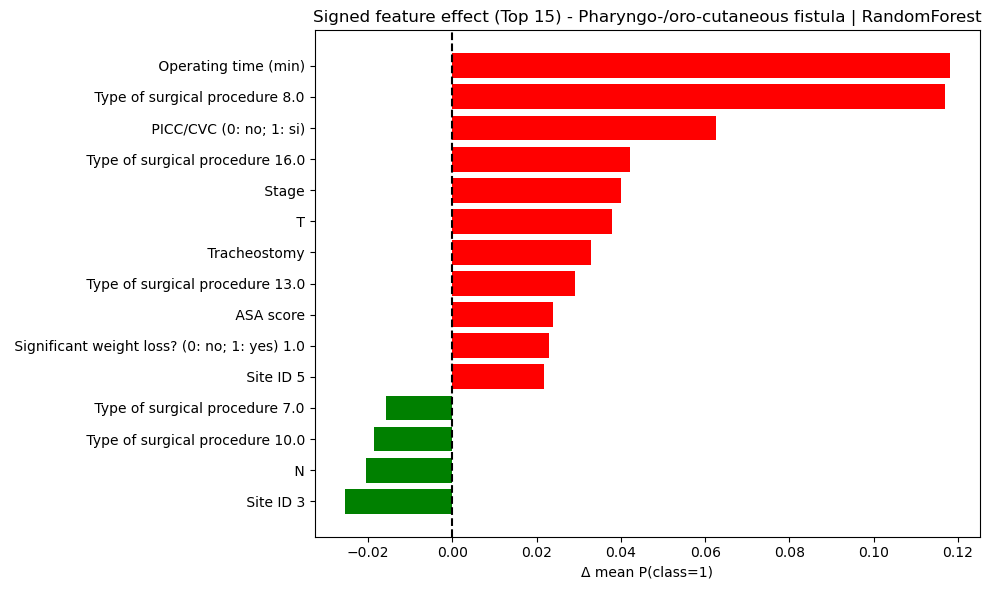


=== SIGNED EFFECT Δ mean P(class=1) - target: Nosocomial infection | model: CatBoost ===


,feature,delta_mean_p1,direction
0,Operating time (min),0.218865,+
1,Type of surgical procedure 7.0,0.114942,+
2,Type of surgical procedure 17.0,0.112655,+
3,Tracheostomy,0.103787,+
4,"Type of surgery (1=clean, 2=clean-contaminate...",0.101782,+
5,Stage,0.092282,+
6,"Type of surgery (1=clean, 2=clean-contaminate...",-0.066111,-
7,ASA score,0.047338,+
8,Age at diagnosis,0.046470,+
9,BMI,-0.045046,-


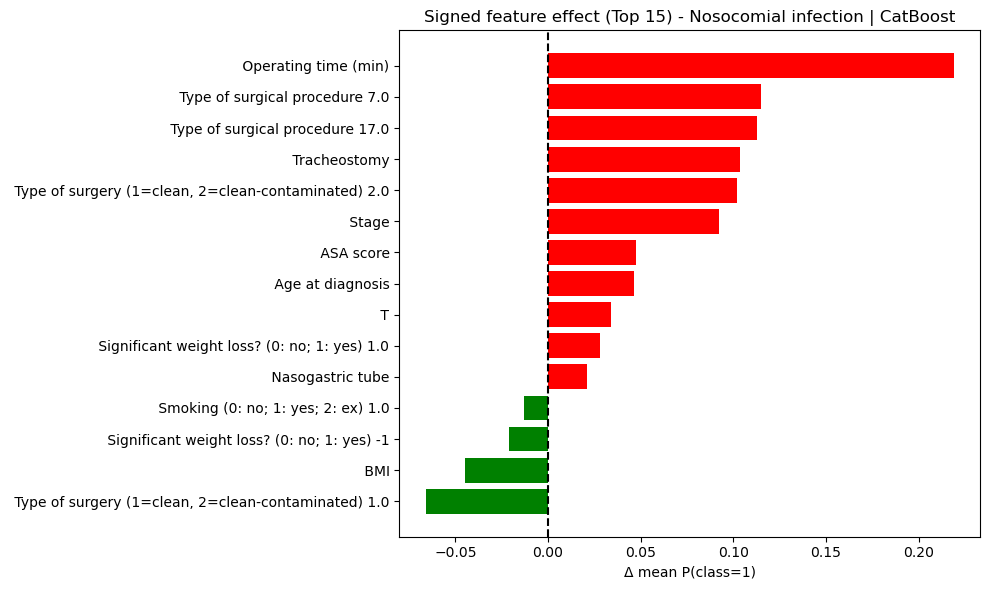

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse

SIGNED_EFFECT_TOP_N = 15
SIGNED_EFFECT_MAX_ROWS = 200
SIGNED_EFFECT_RANDOM_STATE = 42

def _clean_feature_names(feature_names_raw):
    """Remove num_ and cat_ prefixes and replace underscores with spaces"""
    cleaned = []
    for name in feature_names_raw:
        # Rimuovi i prefissi
        if name.startswith("num_"):
            name = name[4:]
        elif name.startswith("cat_"):
            name = name[4:]
        
        # Sostituisci underscore rimanenti con spazi
        name = name.replace("_", " ")
        cleaned.append(name)
    return cleaned

def _get_preprocess_and_clf(pipe):
    """Extract the preprocessor and the classifier from a pipeline"""
    if not hasattr(pipe, "named_steps"):
        raise TypeError("Expected a Pipeline with named_steps")
    if "preprocess" not in pipe.named_steps or "clf" not in pipe.named_steps:
        raise KeyError("Pipeline must have steps named 'preprocess' and 'clf'")
    return pipe.named_steps["preprocess"], pipe.named_steps["clf"]

def signed_effect_preprocessed(pipe, X_df: pd.DataFrame, max_rows=200, random_state=42):
    pre, clf = _get_preprocess_and_clf(pipe)

    # Subsample for stability
    Xs = (
        X_df.sample(n=min(len(X_df), int(max_rows)), random_state=random_state)
        if max_rows else X_df.copy()
    )

    # Transform via preprocessor
    Xt = pre.transform(Xs)
    Xt = Xt.toarray() if hasattr(Xt, "toarray") else np.asarray(Xt)

    # Feature names in transformed space - CLEAN VERSION
    try:
        feat_names_raw = pre.get_feature_names_out()
        feat_names = _clean_feature_names(feat_names_raw)
    except Exception:
        feat_names = [f"f{j}" for j in range(Xt.shape[1])]

    effects = []
    for j in range(Xt.shape[1]):
        col = Xt[:, j]
        uniq = np.unique(col)
        X_low = Xt.copy()
        X_high = Xt.copy()

        # Binary feature: 0 vs 1
        if uniq.size <= 2 and set(np.round(uniq, 6)).issubset({0.0, 1.0}):
            X_low[:, j] = 0.0
            X_high[:, j] = 1.0
        else:  # Continuous feature: Q1 vs Q3
            q1 = np.quantile(col, 0.25)
            q3 = np.quantile(col, 0.75)
            X_low[:, j] = q1
            X_high[:, j] = q3

        p_low = clf.predict_proba(X_low)[:, 1].mean()
        p_high = clf.predict_proba(X_high)[:, 1].mean()
        effects.append(float(p_high - p_low))

    dir_df = (
        pd.DataFrame({
            "feature": feat_names,
            "delta_mean_p1": effects,
            "abs_effect": np.abs(effects)
        })
        .sort_values("abs_effect", ascending=False)
        .reset_index(drop=True)
    )

    # Sign column: "+" if positive (pushes toward class 1), "-" if negative (pushes toward class 0)
    dir_df["direction"] = dir_df["delta_mean_p1"].apply(lambda x: "+" if x > 0 else "-")

    return dir_df

print("\n================= SIGNED FEATURE EFFECT =================")
signed_effect_by_target = {}

for target in TARGETS_TO_RUN:
    if target not in best_estimators_by_target:
        continue

    pipe = best_estimators_by_target[target]
    model_name = val_best_df.loc[val_best_df["target"] == target, "model"].iloc[0]

    dir_df = signed_effect_preprocessed(
        pipe,
        X_test,
        max_rows=SIGNED_EFFECT_MAX_ROWS,
        random_state=SIGNED_EFFECT_RANDOM_STATE
    )
    signed_effect_by_target[target] = dir_df

    # Select top N features by absolute effect
    top_df = dir_df.head(SIGNED_EFFECT_TOP_N)

    print(
        f"\n=== SIGNED EFFECT Δ mean P(class=1) "
        f"- target: {target} | model: {model_name} ==="
    )
    display(top_df[["feature", "delta_mean_p1", "direction"]])  # show top N with sign

    # Plot: sort by actual delta to keep red/green bars consistent
    top_df_plot = top_df.sort_values("delta_mean_p1")
    plt.figure(figsize=(10, 6))
    colors = ["red" if x > 0 else "green" for x in top_df_plot["delta_mean_p1"]]
    plt.barh(top_df_plot["feature"], top_df_plot["delta_mean_p1"], color=colors)
    plt.axvline(0, linestyle="--", color="black")
    plt.title(
        f"Signed feature effect (Top {SIGNED_EFFECT_TOP_N}) "
        f"- {target} | {model_name}"
    )
    plt.xlabel("Δ mean P(class=1)")
    plt.tight_layout()
    plt.savefig(os.path.join(plots_folder, f"{safe_filename(target)}_{safe_filename(model_name)}_signed_effect.png"))
    plt.show()

Interpretation of Results

**Fistula:**  
- The feature with the largest positive effect is **Operating time (min)**: increasing from Q1 to Q3 shifts the predicted probability toward 1 by **+0.12** (12%).
- **Type of surgical procedure 8.0** (total laryngectomy) and **PICC/CVC** also strongly push the probability toward 1.
- **Stage**, **T**, **Tracheostomy**, and **ASA score** are all positive contributors, meaning they move the model output toward 1.
- Some features, such as **Site ID 3**, **N**, and certain procedure types, have negative signed effects, meaning they push the probability toward 0.

**Nosocomial infection:**  
- **Operating time (min)** shifts the predicted probability toward 1 by **+0.22** (22%).
- **Type of surgical procedure 7.0** (partial laryngectomy), **procedure 17.0**, and **Tracheostomy** all substantially push the probability toward 1.
- **Type of surgery (clean-contaminated)**, **Stage**, and **ASA score** are also important positive contributors.
- Some features, such as **Type of surgery (clean)**, **BMI**, and **Smoking (yes)**, have negative signed effects, pushing the probability toward 0.

In [26]:
# === SAVE FEATURE IMPORTANCE / SIGNED EFFECT AND SHAP VALUES ===
for target in TARGETS_TO_RUN:
    # 1. Save signed effect/feature importance
    if target in signed_effect_by_target:
        feat_imp_df = signed_effect_by_target[target].copy()
        feat_imp_df["target"] = target
        target_clean = safe_filename(target)
        feat_imp_file = os.path.join(results_tables_folder, f"feature_importance_{target_clean}.csv")
        feat_imp_df.to_csv(feat_imp_file, index=False)
        print(f"✓ Feature importance for '{target}' saved: {feat_imp_file}")

    # 2. Save SHAP values (if available)
    if "shap_values" in globals() and "feature_names" in globals():
        try:
            # Assumi che shap_values e feature_names siano già calcolati per questo target
            shap_df = pd.DataFrame(shap_values, columns=feature_names)
            shap_file = os.path.join(results_tables_folder, f"shap_values_{target_clean}.csv")
            shap_df.to_csv(shap_file, index=False)
            print(f"✓ SHAP values for '{target}' saved: {shap_file}")
        except Exception as e:
            print(f"✗ Could not save SHAP values for '{target}': {e}")

✓ Feature importance for 'Pharyngo-/oro-cutaneous fistula' saved: model_results/results_tables/feature_importance_Pharyngo-_oro-cutaneous_fistula.csv
✓ SHAP values for 'Pharyngo-/oro-cutaneous fistula' saved: model_results/results_tables/shap_values_Pharyngo-_oro-cutaneous_fistula.csv
✓ Feature importance for 'Nosocomial infection' saved: model_results/results_tables/feature_importance_Nosocomial_infection.csv
✓ SHAP values for 'Nosocomial infection' saved: model_results/results_tables/shap_values_Nosocomial_infection.csv


# Visualizing Model Performance - PR-AUC and ROC-AUC Curves

Now let's plot the Precision-Recall and ROC curves to see how well our models perform at different thresholds. We'll mark the threshold we actually chose for each model so you can see where we're operating on the curve.


PLOTTING PR-AUC AND ROC-AUC CURVES WITH OPTIMAL THRESHOLDS


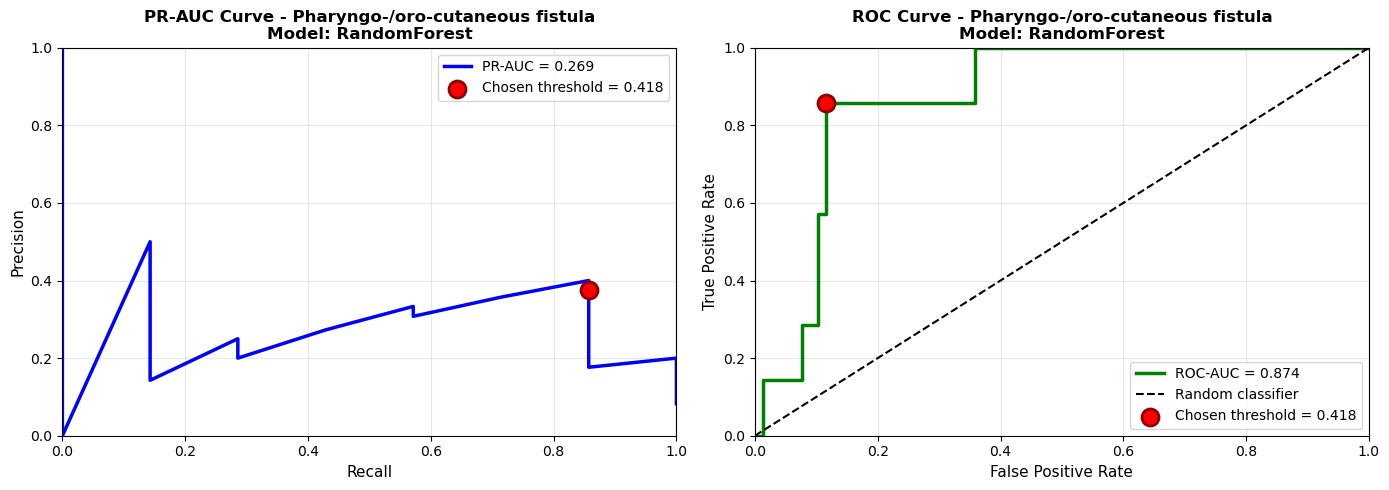


✓ Pharyngo-/oro-cutaneous fistula
  Model: RandomForest
  Optimal threshold: 0.4183
  At this threshold - Precision: 0.375, Recall: 0.857
  PR-AUC: 0.2693 | ROC-AUC: 0.8736


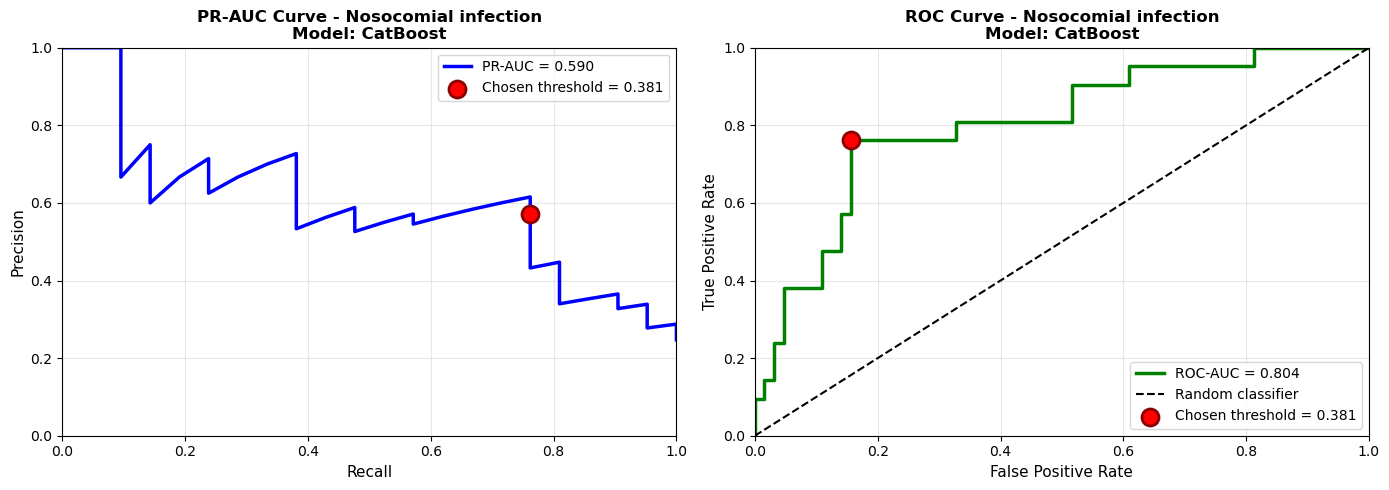


✓ Nosocomial infection
  Model: CatBoost
  Optimal threshold: 0.3806
  At this threshold - Precision: 0.571, Recall: 0.762
  PR-AUC: 0.5899 | ROC-AUC: 0.8036



In [27]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score, roc_auc_score

print("\n" + "="*80)
print("PLOTTING PR-AUC AND ROC-AUC CURVES WITH OPTIMAL THRESHOLDS")
print("="*80)

for target in TARGETS_TO_RUN:
    if target not in best_estimators_by_target:
        continue

    pipe = best_estimators_by_target[target]
    threshold = best_thresholds_by_target[target]
    model_name = val_best_df.loc[val_best_df["target"] == target, "model"].iloc[0]

    # Get predictions for test set
    y_test_target = y_test[target].values
    y_pred_proba = pipe.predict_proba(X_test)[:, 1]

    # Calculate PR and ROC curves
    precision, recall, pr_thresholds = precision_recall_curve(y_test_target, y_pred_proba)
    fpr, tpr, roc_thresholds = roc_curve(y_test_target, y_pred_proba)

    pr_auc_val = auc(recall, precision)
    roc_auc_val = auc(fpr, tpr)

    # Find where our chosen threshold is on the curves
    idx_pr = np.argmin(np.abs(pr_thresholds[:-1] - threshold))  # pr_thresholds has one extra value
    recall_at_thresh = recall[idx_pr]
    precision_at_thresh = precision[idx_pr]

    idx_roc = np.argmin(np.abs(roc_thresholds - threshold))
    fpr_at_thresh = fpr[idx_roc]
    tpr_at_thresh = tpr[idx_roc]

    # Plot both curves side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # PR-AUC Curve
    axes[0].plot(recall, precision, color='blue', lw=2.5, label=f'PR-AUC = {pr_auc_val:.3f}')
    axes[0].scatter(recall_at_thresh, precision_at_thresh, color='red', s=150, zorder=5, label=f'Chosen threshold = {threshold:.3f}', edgecolors='darkred', linewidth=2)
    axes[0].set_xlabel('Recall', fontsize=11)
    axes[0].set_ylabel('Precision', fontsize=11)
    axes[0].set_title(f'PR-AUC Curve - {target}\nModel: {model_name}', fontsize=12, fontweight='bold')
    axes[0].legend(loc='best', fontsize=10)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim([0, 1])
    axes[0].set_ylim([0, 1])

    # ROC Curve
    axes[1].plot(fpr, tpr, color='green', lw=2.5, label=f'ROC-AUC = {roc_auc_val:.3f}')
    axes[1].plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random classifier')
    axes[1].scatter(fpr_at_thresh, tpr_at_thresh, color='red', s=150, zorder=5,
                   label=f'Chosen threshold = {threshold:.3f}', edgecolors='darkred', linewidth=2)
    axes[1].set_xlabel('False Positive Rate', fontsize=11)
    axes[1].set_ylabel('True Positive Rate', fontsize=11)
    axes[1].set_title(f'ROC Curve - {target}\nModel: {model_name}', fontsize=12, fontweight='bold')
    axes[1].legend(loc='best', fontsize=10)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlim([0, 1])
    axes[1].set_ylim([0, 1])

    plt.tight_layout()
    plt.savefig(os.path.join(plots_folder, f"{safe_filename(target)}_{safe_filename(model_name)}_pr_roc_curves.png"))
    plt.show()

    print(f"\n✓ {target}")
    print(f"  Model: {model_name}")
    print(f"  Optimal threshold: {threshold:.4f}")
    print(f"  At this threshold - Precision: {precision_at_thresh:.3f}, Recall: {recall_at_thresh:.3f}")
    print(f"  PR-AUC: {pr_auc_val:.4f} | ROC-AUC: {roc_auc_val:.4f}")

print("\n" + "="*80)

# Saving Results to Files

All results have been saved and organized in the `model_results/` directory with the following structure:

**`results_tables/` folder - CSV summaries and detailed metrics:**
- `optimal_thresholds_summary.csv` - Best model and optimal probability threshold per target
- `test_best_summary.csv` - Final test set metrics (accuracy, precision, recall, F1, ROC-AUC, PR-AUC, MCC) with confusion matrix
- `val_best_summary.csv` - Validation results for best models at both default (0.5) and optimized thresholds
- `val_all_models.csv` - Validation results for all candidate models across all thresholds
- `{target}_val_metrics_by_threshold.csv` - Per-model detailed metrics across 91 probability thresholds for threshold sensitivity analysis
- `{target}_val_summary.csv` - Validation summary per target showing all candidates ranked
- `feature_importance_{target}.csv` - Signed feature effects (Δ mean P(class=1)) showing which features increase/decrease risk

**`plots/` folder - Visualizations and interpretability plots:**

For each target-model combination:

- `{target}_{model}_shap_bar.png` - Top 15 SHAP features (bar chart)
- `{target}_{model}_shap_beeswarm.png` - SHAP distributions (beeswarm plot with feature values)
- `{target}_{model}_shap_dependence.png` - Top 5 feature dependencies (5 scatter plots)
- `{target}_{model}_signed_effect.png` - Signed feature effects (red = ↑ risk, green = ↓ risk)
- `{target}_{model}_pr_roc_curves.png` - PR-AUC & ROC-AUC curves with optimal threshold marked

Where `{target}` = target variable name and `{model}` = winning model name.

This organization allows easy access to model performance metrics, threshold analysis, feature importance rankings, and visual interpretability plots for clinical interpretation.

---

# What We Found and What It Means

## What the Models Tell Us

So after training all the models and testing them, here's what worked and what didn't:

- **RandomForest achieved the best performance for fistula prediction** (validation F1_pos = 0.714, PR-AUC = 0.474, threshold = 0.42), with a score on test set F1_pos of 0.522 and PR-AUC of 0.330. LogisticRegression and XGBoost delivered similar but slightly lower results.
- **For nosocomial infection, CatBoost was the top performer** (validation F1_pos = 0.8, PR-AUC = 0.671, threshold = 0.38), with a test F1_pos of 0.653 and PR-AUC of 0.603. RandomForest and LogisticRegression followed closely.
- Threshold tuning is crucial: Instead of always using 0.5, we selected the threshold that maximized F1 for each complication, which improved the balance between sensitivity and specificity. We also report metrics for both the default (0.5) and the optimized threshold for transparency.
- **Our cross-validation was stable** - the 5-fold CV with stratification meant we weren't overfitting to one particular split of the data.

## How This Could Help Doctors

If a hospital wanted to use these models:
- They could input patient data before surgery and get a predicted probability score (between 0 and 1) for each complication.
- For fistula, the model can indicate which patients are more or less likely to develop the complication, based on their profile.
- For nosocomial infection, similarly, the doctor can see which patients have a higher predicted probability of developing the complication.
- This information can support clinical decision-making, helping doctors to prioritize monitoring, prepare interventions, or adjust their surgical approach as needed.

## What Could Be Better (and What We'd Do Next)

**Challenges we faced**:
- We only had 396 training examples after cleaning, which is small for machine learning.
- Complications are rare (8% fistula, 24% infection), so the models had to work harder to learn.

**It would be better to**:
- Collect more patient data from more hospitals
- Validate the models on external, unseen patient cohorts to assess real-world performance.